In [23]:
import sys
sys.path.append('C:\\Users\\user\\PycharmProjects\\pipeGEM')

from pathlib import Path
import cobra
import pandas as pd
import numpy as np
import pipeGEM as pg
from pipeGEM.utils import load_model, save_model, get_subsystems
from pipeGEM.pipeline.algo import SwiftCore, SwiftCC, rFastCormics, FastCC
from pipeGEM.pipeline.task import TaskScoringPipeLine
from pipeGEM.pipeline.threshold import BimodalThreshold
from pipeGEM.integration.mapping import Expression
from pipeGEM.integration.constraints.GIMME import _GIMME_post_process
from pipeGEM.integration.constraints.RIPTiDe import RIPTiDe
from cobra.flux_analysis.parsimonious import pfba
from cobra.sampling import sample

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
model_path = "../models/2022March/"

In [25]:
mg_TPMs = pd.read_csv("../data/mg_tpm_2203.tsv", sep='\t')

mg_TPMs["gene"] = mg_TPMs["gene"].apply(lambda x: x[:x.index(".")] if "." in x else x)
mg_TPMs = mg_TPMs.groupby("gene").sum()

In [4]:
mg_RLE = pd.read_csv("../data/mg_RLE.tsv", sep='\t')
mg_RLE["gene"] = mg_RLE["gene"].apply(lambda x: x[:x.index(".")] if "." in x else x)
mg_RLE = mg_RLE.groupby("gene").sum()

In [83]:
human = load_model("../models/Human-GEM_1110.mat")
# human = load_model("../models/chuman.mat")
for r in human.reactions:
    r.subsystem = r.subsystem[r.subsystem.index("(['")+3: r.subsystem.index("']")]

In [13]:
serum = pd.read_csv("../serum_mod.csv")

In [9]:
dmem_medium_path = Path("../data/ac16_fluxes.csv")
dmem_medium = pd.read_csv(dmem_medium_path, index_col=0)
rxn_map = {}
ex_rxns = [r.id for r in human.exchanges]
for m in human.metabolites:
    if not any([(met+ "e")== (m.id) for met in dmem_medium["human_gem"] if pd.notna(met)]) :
        continue
    for r in m.reactions:
        if r.id in ex_rxns:
            rxn_map[m.id[:-1]] = r.id
dmem_medium["human_gem_rxn"] = dmem_medium["human_gem"].map(rxn_map)

inorg_met_ids = ['MAM02200','MAM02609', 'MAM02949','MAM02946',
                 'MAM01821','MAM01822', 'MAM01442','MAM01413',
                 'MAM03157','MAM02751', 'MAM02147','MAM02040',
                 'MAM02588','MAM02630', 'MAM02759','MAM02579',
                 'MAM03157','MAM01596', 'MAM02959','MAM02519', 'MAM02046']
rxn_map = {}
ex_rxns = [r.id for r in human.exchanges]
inorg_rxns = []
for m in human.metabolites:
    if not any([(met+ "e")== (m.id) for met in inorg_met_ids if pd.notna(met)]) :
        continue
    for r in m.reactions:
        if r.id in ex_rxns:
            rxn_map[m.id[:-1]] = r.id
            inorg_rxns.append(r.id)

In [18]:
rxn_map = {}
ex_rxns = [r.id for r in human.exchanges]
for m in human.metabolites:
    if not any([(met+ "e")== (m.id) for met in serum["met_id"] if pd.notna(met)]) :
        continue
    for r in m.reactions:
        if r.id in ex_rxns:
            rxn_map[m.id[:-1]] = r.id

In [71]:
serum[pd.isna(serum["rxn_id"])]

,met_id,concentration,rxn_id
6,MAM00285,8.419994e-08,NaN
13,MAM00336,2.904280e-04,NaN
26,MAM00569,3.732864e+00,NaN
32,MAM00603,1.282646e-05,NaN
37,MAM00631,5.613329e-04,NaN
41,MAM00653,3.367998e-03,NaN
53,MAM00761,2.806665e-04,NaN
59,MAM00819,6.707928e-05,NaN
64,MAM00918,4.659063e-03,NaN
65,MAM00943,3.396064e-07,NaN


In [23]:
serum["rxn_id"] = serum["met_id"].map(rxn_map)

In [67]:
serum.loc[serum["rxn_id"] == "MAR00569", "concentration"] = 0

In [104]:
for r in human.exchanges:
    r.bounds = (0, 1000)

for i, r in serum.iterrows():
    if pd.isna(r["rxn_id"]) or r["rxn_id"] == "MAR00569":
        continue
    if r["rxn_id"] in dmem_medium["human_gem_rxn"].to_list():
        human.reactions.get_by_id(r["rxn_id"]).lower_bound = -min(max(r["concentration"], 1) * 3, 1000)
    else:
        human.reactions.get_by_id(r["rxn_id"]).lower_bound = -min(max(r["concentration"], 1e-4), 1000)

for r in ['MAR00656', 'MAR09152', 'MAR09153', 'MAR09154', 'MAR09386', 'MAR13067', 'MAR09048']:
    human.reactions.get_by_id(r).lower_bound = -20
    
for r in inorg_rxns:
    human.reactions.get_by_id(r).lower_bound = -1000

In [64]:
from cobra.flux_analysis.parsimonious import pfba

In [72]:
for r in human.exchanges:
    if r.id in inorg_rxns:
        r.lower_bound = -1000
    elif r.id in dmem_medium["human_gem_rxn"] or r.id in ["MAR00656", "MAR00696", 'MAR09152', 
                                                          'MAR09153', 'MAR09154', 'MAR13067', 
                                                          'MAR09048']: # essential
        r.lower_bound = -20
    else:
        r.lower_bound = -0.01

In [105]:
human.summary(pfba(human))

In [106]:
fastcc = FastCC()
fastcc(human, tol=1e-4, is_convex=True)
fastcc(fastcc.output["model"], tol=1e-4, is_convex=False)

c_model = fastcc.output["model"].copy()
save_model(c_model, "../models/c_human", ".json")

Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpn7fmoapz.lp
Reading time = 0.07 seconds
: 8366 rows, 26138 columns, 111670 nonzeros
[Removed]  {'MAR07604'} is flux inconsistent.
[Removed]  {'MAR06882'} is flux inconsistent.
[Removed]  {'MAR03994'} is flux inconsistent.
[Removed]  {'MAR03048'} is flux inconsistent.
[Removed]  {'MAR12722'} is flux inconsistent.
[Removed]  {'MAR02109'} is flux inconsistent.
[Removed]  {'MAR02108'} is flux inconsistent.
[Removed]  {'MAR11302'} is flux inconsistent.
[Removed]  {'MAR08048'} is flux inconsistent.
[Removed]  {'MAR03821'} is flux inconsistent.
[Removed]  {'MAR10456'} is flux inconsistent.
[Removed]  {'MAR12882'} is flux inconsistent.
[Removed]  {'MAR06880'} is flux inconsistent.
[Removed]  {'MAR07048'} is flux inconsistent.
[Removed]  {'MAR12433'} is flux inconsistent.
[Removed]  {'MAR02120'} is flux inconsistent.
[Removed]  {'MAR12900'} is flux inconsistent.
[Removed]  {'MAR02066'} is flux inconsistent.


In [112]:
#fastcc(c_model, tol=1e-4, is_convex=True)
fastcc(fastcc.output["model"], tol=1e-4, is_convex=False)


Using non-convex fastcc method
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpqh066sbc.lp
Reading time = 0.06 seconds
: 6341 rows, 21418 columns, 91210 nonzeros


{'model': <Model ihuman at 0x1d22ffc5668>,
 'removed_rxn_ids': ['MAR06426', 'MAR06428'],
 'rxn_ids': {'MAR04150',
  'MAR01754',
  'MAR01550',
  'MAR03698',
  'MAR04849',
  'MAR06233',
  'MAR04193',
  'MAR03639',
  'MAR06440',
  'MAR03384',
  'MAR03147',
  'MAR07296',
  'MAR05080',
  'MAR02225',
  'MAR04576',
  'MAR01109',
  'MAR01328',
  'MAR11028',
  'MAR05322',
  'MAR00066',
  'MAR04453',
  'MAR10466',
  'MAR06258',
  'MAR04580',
  'MAR09463',
  'MAR00114',
  'MAR11988',
  'MAR04032',
  'MAR03664',
  'MAR10440',
  'MAR05587',
  'MAR05570',
  'MAR10512',
  'MAR02206',
  'MAR04388',
  'MAR11726',
  'MAR04897',
  'MAR03996',
  'MAR06010',
  'MAR09285',
  'MAR02340',
  'MAR01031',
  'MAR09187',
  'MAR05091',
  'MAR03192',
  'MAR11253',
  'MAR12022',
  'MAR06656',
  'MAR11772',
  'MAR00579',
  'MAR07257',
  'MAR10741',
  'MAR03286',
  'MAR00839',
  'MAR03800',
  'MAR02342',
  'MAR05338',
  'MAR01928',
  'MAR04806',
  'MAR08455',
  'MAR06741',
  'MAR05020',
  'MAR06764',
  'MAR01167',
  'M

In [116]:
c_model.reactions.get_by_id("MAR03489")

Reaction identifier,MAR03489
Name,
Memory address,0x01d151335198
Stoichiometry,"MAM00077x + MAM01371x + MAM01597x <=> MAM00078x + MAM01334x + MAM02759x (2R,6S,10S)-pristanate + ATP + CoA <=> (2S)-pristanoyl-CoA + AMP + PPi"
GPR,ENSG00000068366 or ENSG00000103740 or ENSG00000119673 or ENSG00000123983 or ENSG00000130377 or EN...
Lower bound,-1000.0
Upper bound,1000.0


In [113]:
c_model = fastcc.output["model"].copy()


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmplrwxpt5n.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


In [115]:
save_model(c_model, "../models/c_human", ".json")

In [58]:
human

Name,ihuman
Memory address,0x01d147575f98
Number of metabolites,8366
Number of reactions,13069
Number of groups,0
Objective expression,1.0*MAR13082 - 1.0*MAR13082_reverse_11d67
Compartments,"c, e, l, r, m, x, g, n, i"


original guess:  -2.1448977805868967 -0.234754699044748
fitted Amps:  0.05746562538779773 0.08929187802874142
fitted means:  -4.089666551069561 -0.9939601454311139


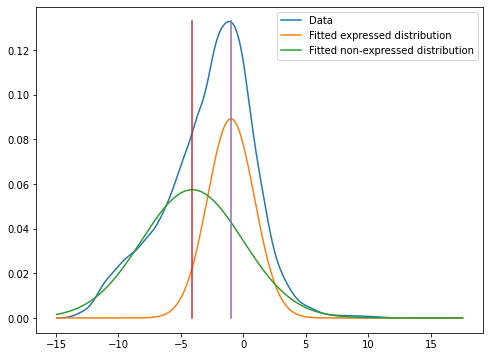

Fitted values: 
-0.9939601454311139 -4.089666551069561
Task Full_29 cannot generate input metabolites
Task Full_30 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

Task 2.0 cannot generate input metabolites
Task 2.0 cannot generate output metabolites
Task 4.0 cannot generate input metabolites
Task 4.0 cannot generate output metabolites
Task 8.0 cannot generate input metabolites
Task 13.0 cannot generate input metabolites
Task 14.0 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 24.0 cannot generate input metabolites
Task 30.0 cannot generate input metabolites
Task 30.0 cannot generate output metabolites
Task 31.0 cannot generate input metabolites
Task 36.0 cannot generate input metabolites
Task 36.0 cannot generate output metabolites
Task 37.0 cannot generate input metabolites
Task 38.0 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
Task 61.0 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 66.0 cannot generate input metabolites
Task 66.0 cannot generate output metabolites
Task 70.0 cannot generate input metabolites
Task 70.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 77.0 cannot generate input metabolites
Task 77.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 88.0 cannot generate input metabolites
Task 88.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 92.0 cannot generate input metabolites
Task 92.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 104.0 cannot generate input metabolites
Task 104.0 cannot generate output metabolites
Task 106.0 cannot generate input metabolites
Task 106.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 111.0 cannot generate input metabolites
Task 111.0 cannot generate output metabolites
Task 119.0 cannot generate input metabolites
Task 119.0 cannot generate output metabolites
Task 121.0 cannot generate input metabolites
Task 121.0 cannot generate output metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 132.0 cannot generate input metabolites
Task 136.0 cannot generate input metabolites
Task 136.0 cannot generate output metabolites
Task 137.0 cannot generate input metabolites
Task 138.0 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


Task 151.0 cannot generate input metabolites
Task 153.0 cannot generate input metabolites
Task 155.0 cannot generate input metabolites
Task 157.0 cannot generate input metabolites
Task 159.0 cannot generate input metabolites
Task 163.0 cannot generate input metabolites


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
Task 178.0 cannot generate input metabolites
Task 178.0 cannot generate output metabolites
MAM01822c not exists in the model
MAM01957c not exists in the model
Task 182.0 cannot generate input metabolites
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
Task 189.0 cannot generate input metabolites
Task 189.0 cannot generate output metabolites
Task 190.0 cannot generat

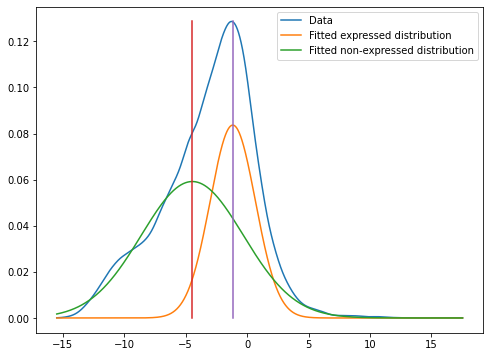

Fitted values: 
-1.1633505338688983 -4.456907651639957
original guess:  -1.665211845600874 -0.4305555812361508
fitted Amps:  0.05774576038879936 0.08246668113987567
fitted means:  -4.5797798113159045 -1.1528540480484322


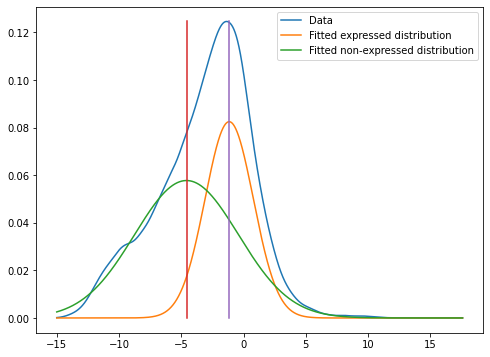

Fitted values: 
-1.1528540480484322 -4.5797798113159045
original guess:  -10.445701929252127 -0.9488341744809716
fitted Amps:  0.0614518244904832 0.0829839029089923
fitted means:  -4.752632104947068 -1.5466975369998346


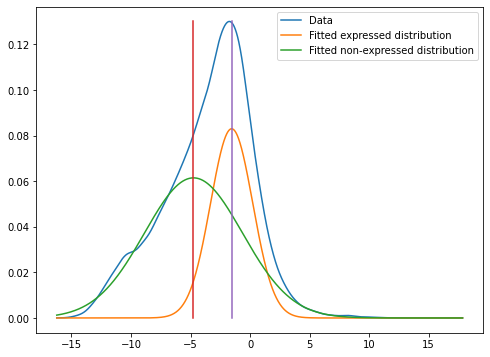

Fitted values: 
-1.5466975369998346 -4.752632104947068
original guess:  -2.848290937899012 -0.524607799235504
fitted Amps:  0.05766644795987133 0.08244089030821586
fitted means:  -4.431612039516739 -1.238058391082745


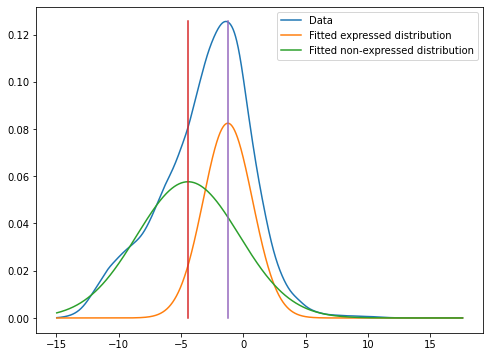

Fitted values: 
-1.238058391082745 -4.431612039516739
original guess:  -4.666431055925825 -1.0806738402396814
fitted Amps:  0.05934387970102803 0.08377828240372767
fitted means:  -4.869890647437362 -1.6875454328374053


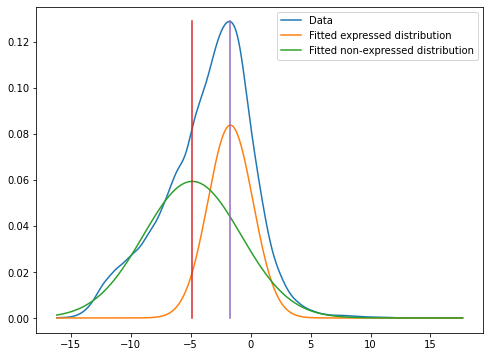

Fitted values: 
-1.6875454328374053 -4.869890647437362
original guess:  -3.1147611876936576 -2.120310532388981
fitted Amps:  0.0547770565761854 0.08204480952071119
fitted means:  -5.9392204024896404 -2.962163126447968


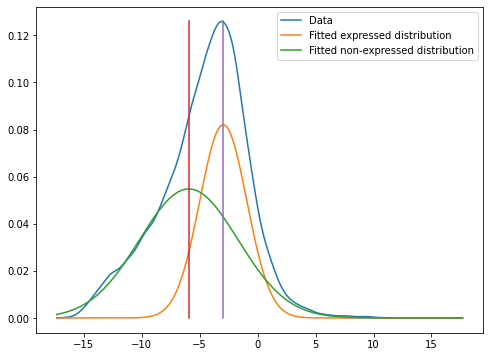

Fitted values: 
-2.962163126447968 -5.9392204024896404
original guess:  -3.1125722109935694 -1.7618087775055393
fitted Amps:  0.055943210043416014 0.07781243932509294
fitted means:  -5.469890302513736 -2.5784483013485278


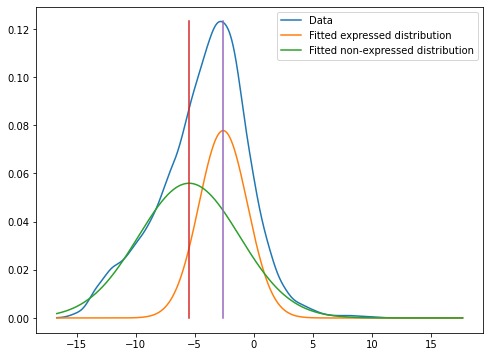

Fitted values: 
-2.5784483013485278 -5.469890302513736
original guess:  -4.133945952425247 -3.0241474137818667
fitted Amps:  0.04829662266163027 0.07488404951969847
fitted means:  -5.291629300305443 -2.749770361334388


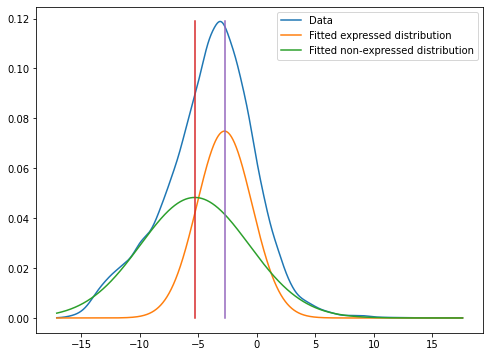

Fitted values: 
-2.749770361334388 -5.291629300305443
original guess:  -3.9803562512497415 -1.4024521956686407
fitted Amps:  0.05686545650548539 0.08319461377733472
fitted means:  -5.198274294467221 -1.8507456521076624


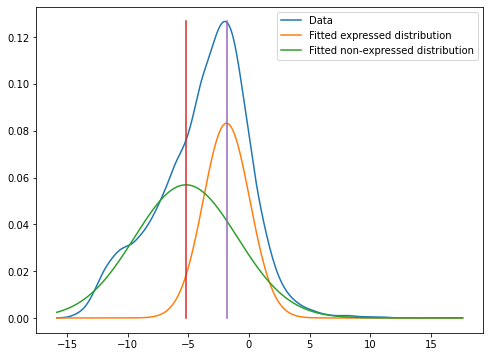

Fitted values: 
-1.8507456521076624 -5.198274294467221
original guess:  -3.972224717464396 -1.7371943187604568
fitted Amps:  0.05606673083054559 0.0829676391652603
fitted means:  -5.209621305123064 -1.9329523221999818


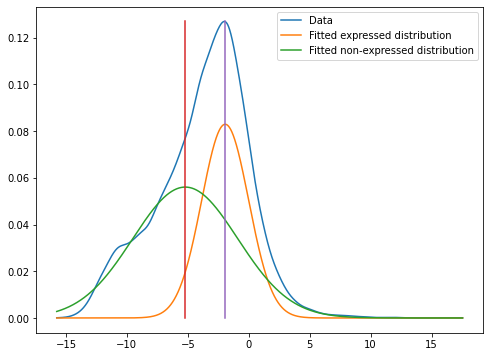

Fitted values: 
-1.9329523221999818 -5.209621305123064
original guess:  -3.7163523216589045 0.14924208195230015
fitted Amps:  0.06270649919099373 0.08414342683371036
fitted means:  -3.4626954778217383 -0.20792949188155402


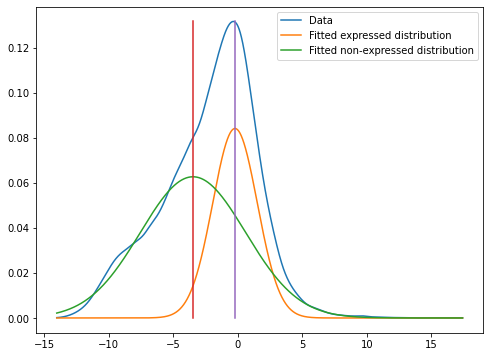

Fitted values: 
-0.20792949188155402 -3.4626954778217383
Find 3987 supporting reactions for protected rxns in  C002A
2357 reactions added to Core reactions
356 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp3jx5cfg_.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros
rxns to be examined: 530
rxns to be examined: 520
rxns to be examined: 520
rxns to be examined: 520
rxns to be examined: 518
rxns to be examined: 518
rxns to be examined: 518
rxns to be examined: 517
rxns to be examined: 517
rxns to be examined: 517
rxns to be examined: 516
rxns to be examined: 514
rxns to be examined: 512
rxns to be examined: 424
rxns to be examined: 420
rxns to be examined: 416
rxns to be examined: 416
rxns to be examined: 416
rxns to be examined: 415
rxns to be examined: 415
rxns to be examined: 415
rxns to be examined: 414
rxns to be examined: 414
rxns to be examined: 414
rxns to be examined: 413
rxn

ValueError: too many values to unpack (expected 2)

In [118]:
rfc = rFastCormics(consist_method = None,
                   task_file_path = "../data/tasks/tasks_for_human1.json",
                   task_constr_name = "None",
                   model_compartment_format = "{}",
                   solver="gurobi",
                   cc_threshold=1e-4,
                   core_threshold=1e-4,
                   use_first_guess=False)

output = rfc(c_model,
             mg_TPMs.iloc[:, :12],
             protected_rxns=["MAR13082"],
             not_penalized_subsystem=r"Transport reactions")

for k, v in output['final_model_dic'].items():
    save_model(v, model_path + k, ".json")

In [140]:
rfc = rFastCormics(consist_method = None,
                       task_file_path = "../data/tasks/tasks_for_human1.json",
                       task_constr_name = "None",
                       model_compartment_format = "{}",
                       solver="gurobi",
                       cc_threshold=1e-4,
                       core_threshold=1e-4,
                       use_first_guess=False,
                       rxn_tester=rfc_mod.rxn_tester,
                       expr_tol_dict=rfc_mod.expr_tol_dict,
                       nexpr_tol_dict=rfc_mod.nexpr_tol_dict,
                       task_protected_rxn_dic=rfc_mod.task_protected_rxn_dic,
                       supp_c_dic=rfc_mod.supp_c_dic,
                       supp_p_dic=rfc_mod.supp_p_dic,
                       unp_p_dic=rfc_mod.unp_p_dic,
                       unp_rxn_dic=rfc_mod.unp_rxn_dic,
                       pfree_mod_dic=rfc_mod.pfree_mod_dic,
                       pfree_c_dic=rfc_mod.pfree_c_dic
                      )

original guess:  -0.04030187007604269 0.7955454094142471
fitted Amps:  0.06618625834854541 0.09088903501594438
fitted means:  -2.628636290474424 0.4994806873071072


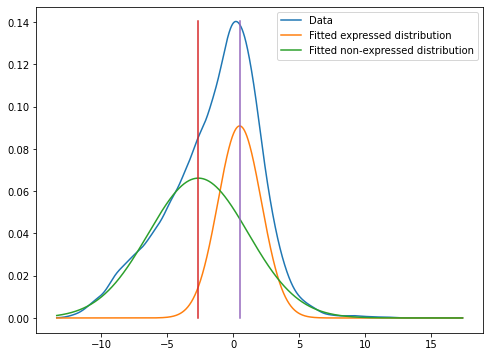

Fitted values: 
0.4994806873071072 -2.628636290474424
original guess:  -5.219111094815908 -3.9354480945473735
fitted Amps:  0.06507114509483287 0.06754618168588941
fitted means:  -7.0130714118502935 -4.386876392626612


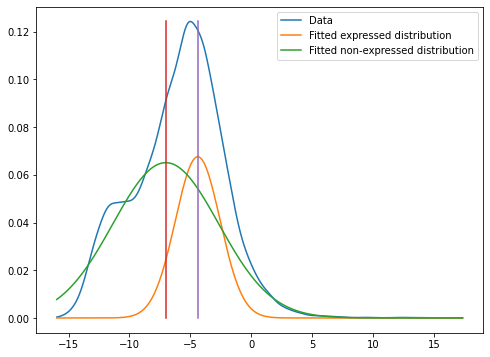

Fitted values: 
-4.386876392626612 -7.0130714118502935
original guess:  -0.6323366888973183 0.16652425323747622
fitted Amps:  0.06572211505964468 0.09001079219811396
fitted means:  -3.4634761997784342 -0.10004177631244766


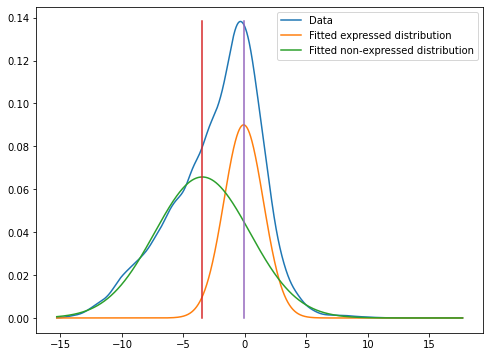

Fitted values: 
-0.10004177631244766 -3.4634761997784342
original guess:  -3.395525948844808 1.274499906347403
fitted Amps:  0.06571014799005542 0.0990187009499677
fitted means:  -2.15725521097543 1.2663494148733028


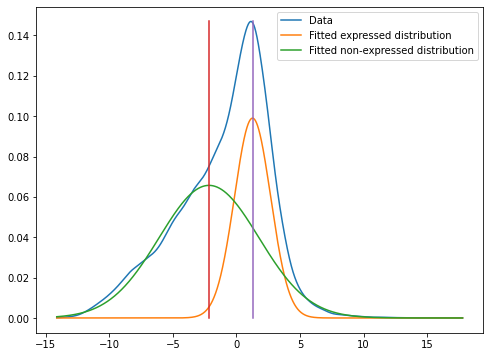

Fitted values: 
1.2663494148733028 -2.15725521097543
original guess:  -11.322058524539788 -0.8625945423872317
fitted Amps:  0.0644903983585745 0.09128910155769981
fitted means:  -4.202719390497679 -1.090358660429967


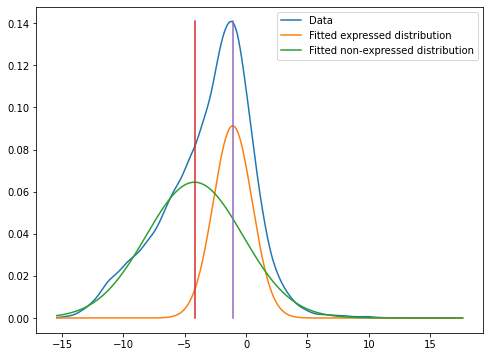

Fitted values: 
-1.090358660429967 -4.202719390497679
original guess:  -1.9754408766417892 -1.0083136538389752
fitted Amps:  0.06078889127879923 0.09792283224375564
fitted means:  -4.418980170752735 -1.1429930923231955


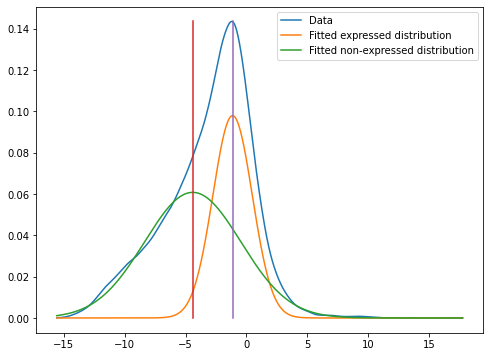

Fitted values: 
-1.1429930923231955 -4.418980170752735
original guess:  -6.3333713492885355 -2.4290209400263567
fitted Amps:  0.06316735480386587 0.08883513296638411
fitted means:  -6.106394766433177 -2.6649810680026214


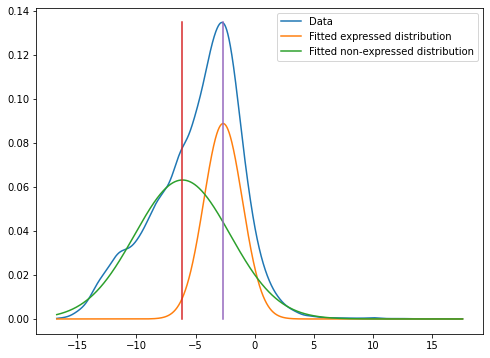

Fitted values: 
-2.6649810680026214 -6.106394766433177


100%|████████████████████████████████████████████████████████████████████████████████| 481/481 [04:07<00:00,  1.95it/s]


Find 3704 supporting reactions for protected rxns in  R050A
2590 reactions added to Core reactions
359 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp0jk0culx.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1492/1492 [03:32<00:00,  7.02it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpwp1ghes_.lp
Reading time = 0.05 seconds
: 5366 rows, 18262 columns, 76936 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 3
 89%|███████████████████████████████████████████████████████████████████████▏        | 553/622 [00:06<00:00, 80.05it/s]

Irrev in J: 0, J: 69


 91%|████████████████████████████████████████████████████████████████████████▍       | 563/622 [00:12<00:01, 39.55it/s]

Irrev in J: 0, J: 59


 94%|██████████████████████████████████████████████████████████████████████████▉     | 583/622 [00:18<00:01, 22.87it/s]

Irrev in J: 0, J: 39


 94%|███████████████████████████████████████████████████████████████████████████▍    | 587/622 [00:24<00:02, 14.14it/s]

Irrev in J: 0, J: 35


 95%|███████████████████████████████████████████████████████████████████████████▉    | 590/622 [00:29<00:03,  9.29it/s]

Irrev in J: 0, J: 32


 95%|████████████████████████████████████████████████████████████████████████████▎   | 593/622 [00:35<00:04,  6.35it/s]

Irrev in J: 0, J: 29


 96%|████████████████████████████████████████████████████████████████████████████▌   | 595/622 [00:41<00:06,  4.40it/s]

Irrev in J: 0, J: 27


 96%|█████████████████████████████████████████████████████████████████████████████   | 599/622 [00:47<00:07,  3.22it/s]

Irrev in J: 0, J: 23


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 602/622 [00:53<00:08,  2.36it/s]

Irrev in J: 0, J: 20


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 604/622 [00:59<00:10,  1.73it/s]

Irrev in J: 0, J: 18


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03489'} flux cannot be generated in LP7
 97%|█████████████████████████████████████████████████████████████████████████████▉  | 606/622 [01:05<00:12,  1.27it/s]

Irrev in J: 0, J: 16


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 608/622 [01:11<00:14,  1.00s/it]

Irrev in J: 0, J: 14


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 610/622 [01:17<00:14,  1.25s/it]

Irrev in J: 0, J: 12


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 612/622 [01:23<00:15,  1.53s/it]

Irrev in J: 0, J: 10


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 614/622 [01:29<00:14,  1.78s/it]

Irrev in J: 0, J: 8


 99%|███████████████████████████████████████████████████████████████████████████████▏| 616/622 [01:34<00:12,  2.00s/it]

Irrev in J: 0, J: 6


100%|███████████████████████████████████████████████████████████████████████████████▋| 620/622 [01:40<00:03,  1.79s/it]

Irrev in J: 0, J: 2


100%|████████████████████████████████████████████████████████████████████████████████| 622/622 [01:46<00:00,  5.85it/s]


Irrev in J: 0, J: 0


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [03:58<00:00,  2.09it/s]


Find 4018 supporting reactions for protected rxns in  R051A
2168 reactions added to Core reactions
454 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpu3164l0q.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1485/1485 [03:57<00:00,  6.24it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp4gs118v0.lp
Reading time = 0.05 seconds
: 5248 rows, 17902 columns, 75564 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 5
 86%|███████████████████████████████████████████████████████████████████▊           | 748/872 [00:05<00:00, 127.25it/s]

Irrev in J: 0, J: 124


 88%|██████████████████████████████████████████████████████████████████████          | 764/872 [00:10<00:01, 60.88it/s]

Irrev in J: 0, J: 108


 91%|█████████████████████████████████████████████████████████████████████████       | 797/872 [00:17<00:02, 32.65it/s]

Irrev in J: 0, J: 75


 92%|█████████████████████████████████████████████████████████████████████████▍      | 801/872 [00:21<00:03, 21.61it/s]

Irrev in J: 0, J: 71


 94%|███████████████████████████████████████████████████████████████████████████▌    | 823/872 [00:26<00:03, 15.57it/s]

Irrev in J: 0, J: 49


 95%|███████████████████████████████████████████████████████████████████████████▊    | 827/872 [00:31<00:04, 10.54it/s]

Irrev in J: 0, J: 45


 95%|████████████████████████████████████████████████████████████████████████████▏   | 830/872 [00:37<00:05,  7.27it/s]

Irrev in J: 0, J: 42


 95%|████████████████████████████████████████████████████████████████████████████▎   | 832/872 [00:41<00:07,  5.27it/s]

Irrev in J: 0, J: 40


 96%|████████████████████████████████████████████████████████████████████████████▌   | 835/872 [00:47<00:09,  3.77it/s]

Irrev in J: 0, J: 37


 96%|████████████████████████████████████████████████████████████████████████████▊   | 837/872 [00:52<00:12,  2.72it/s]

Irrev in J: 0, J: 35


 96%|█████████████████████████████████████████████████████████████████████████████   | 840/872 [00:57<00:15,  2.04it/s]

Irrev in J: 0, J: 32


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 844/872 [01:02<00:16,  1.66it/s]

Irrev in J: 0, J: 28


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 845/872 [01:07<00:21,  1.26it/s]

Irrev in J: 0, J: 27


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 847/872 [01:12<00:25,  1.01s/it]

Irrev in J: 0, J: 25


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 849/872 [01:17<00:28,  1.23s/it]

Irrev in J: 0, J: 23


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 850/872 [01:21<00:34,  1.55s/it]

Irrev in J: 0, J: 22


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 852/872 [01:27<00:35,  1.78s/it]

Irrev in J: 0, J: 20


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 854/872 [01:32<00:35,  1.97s/it]

Irrev in J: 0, J: 18


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 856/872 [01:37<00:33,  2.12s/it]

Irrev in J: 0, J: 16


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR09859'}
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 858/872 [01:43<00:33,  2.41s/it]

Irrev in J: 0, J: 14


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR03887'}
 99%|██████████████████████████████████████████████████████████████████████████████▊ | 859/872 [01:44<00:28,  2.20s/it]C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. 

Irrev in J: 0, J: 11


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR02088'}
 99%|███████████████████████████████████████████████████████████████████████████████ | 862/872 [01:51<00:22,  2.26s/it]C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. 

Irrev in J: 0, J: 7


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR03168'}
 99%|███████████████████████████████████████████████████████████████████████████████▌| 867/872 [02:02<00:12,  2.48s/it]

Irrev in J: 0, J: 5


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR02677'}
100%|███████████████████████████████████████████████████████████████████████████████▋| 869/872 [02:08<00:08,  2.77s/it]

Irrev in J: 0, J: 3


100%|███████████████████████████████████████████████████████████████████████████████▉| 871/872 [02:13<00:02,  2.66s/it]

Irrev in J: 0, J: 1


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03894'} flux cannot be generated in LP7
C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:170 UserWarning: Error: Global network is not consistent. Removed core rxn: {'MAR03894'}
100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [04:22<00:00,  1.76it/s]


Find 3613 supporting reactions for protected rxns in  R053A
2338 reactions added to Core reactions
334 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp4wprhpc_.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1645/1645 [04:44<00:00,  5.79it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpoh_pwyiu.lp
Reading time = 0.05 seconds
: 5113 rows, 17762 columns, 74394 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 3
 85%|███████████████████████████████████████████████████████████████████▉            | 618/728 [00:06<00:01, 99.93it/s]

Irrev in J: 0, J: 110


 88%|██████████████████████████████████████████████████████████████████████▋         | 643/728 [00:11<00:01, 46.76it/s]

Irrev in J: 0, J: 85
Irrev in J: 0, J: 84


 93%|██████████████████████████████████████████████████████████████████████████▌     | 679/728 [00:21<00:02, 20.97it/s]

Irrev in J: 0, J: 49


 93%|██████████████████████████████████████████████████████████████████████████▋     | 680/728 [00:26<00:03, 14.96it/s]

Irrev in J: 0, J: 48


 94%|███████████████████████████████████████████████████████████████████████████▏    | 684/728 [00:31<00:04, 10.51it/s]

Irrev in J: 0, J: 44


 94%|███████████████████████████████████████████████████████████████████████████▍    | 687/728 [00:37<00:05,  7.44it/s]

Irrev in J: 0, J: 41


 95%|███████████████████████████████████████████████████████████████████████████▋    | 689/728 [00:42<00:07,  5.28it/s]

Irrev in J: 0, J: 39


 96%|████████████████████████████████████████████████████████████████████████████▌   | 697/728 [00:47<00:07,  4.13it/s]

Irrev in J: 0, J: 31


 96%|████████████████████████████████████████████████████████████████████████████▊   | 699/728 [00:53<00:09,  2.96it/s]

Irrev in J: 0, J: 29


 96%|█████████████████████████████████████████████████████████████████████████████   | 701/728 [00:58<00:12,  2.18it/s]

Irrev in J: 0, J: 27


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 704/728 [01:04<00:14,  1.68it/s]

Irrev in J: 0, J: 24


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 706/728 [01:09<00:17,  1.27it/s]

Irrev in J: 0, J: 22


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 708/728 [01:15<00:20,  1.00s/it]

Irrev in J: 0, J: 20


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 712/728 [01:20<00:17,  1.09s/it]

Irrev in J: 0, J: 16


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 714/728 [01:26<00:18,  1.32s/it]

Irrev in J: 0, J: 14


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 716/728 [01:31<00:18,  1.55s/it]

Irrev in J: 0, J: 12


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 718/728 [01:37<00:17,  1.78s/it]

Irrev in J: 0, J: 10


 99%|███████████████████████████████████████████████████████████████████████████████ | 720/728 [01:42<00:15,  1.98s/it]

Irrev in J: 0, J: 8


 99%|███████████████████████████████████████████████████████████████████████████████▎| 722/728 [01:47<00:12,  2.14s/it]

Irrev in J: 0, J: 6


100%|███████████████████████████████████████████████████████████████████████████████▊| 726/728 [01:53<00:03,  1.82s/it]

Irrev in J: 0, J: 2


100%|████████████████████████████████████████████████████████████████████████████████| 728/728 [01:58<00:00,  6.14it/s]


Irrev in J: 0, J: 0


100%|████████████████████████████████████████████████████████████████████████████████| 482/482 [03:51<00:00,  2.08it/s]


Find 3345 supporting reactions for protected rxns in  R054A
2249 reactions added to Core reactions
336 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpxmrv2kno.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [04:50<00:00,  5.87it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpdnp6rbop.lp
Reading time = 0.05 seconds
: 5088 rows, 17664 columns, 74048 nonzeros


100%|████████████████████████████████████████████████████████████████████████████████| 470/470 [03:44<00:00,  2.09it/s]


Find 3987 supporting reactions for protected rxns in  R055A
2268 reactions added to Core reactions
364 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp9310t2rh.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1482/1482 [03:33<00:00,  6.94it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpc1i35o72.lp
Reading time = 0.05 seconds
: 5361 rows, 18256 columns, 77198 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 4
 83%|█████████████████████████████████████████████████████████████████▌             | 674/812 [00:06<00:01, 111.35it/s]

Irrev in J: 0, J: 138


 85%|███████████████████████████████████████████████████████████████████▋            | 687/812 [00:11<00:02, 51.86it/s]

Irrev in J: 0, J: 125


 88%|██████████████████████████████████████████████████████████████████████▏         | 712/812 [00:16<00:03, 29.80it/s]

Irrev in J: 0, J: 100


 88%|██████████████████████████████████████████████████████████████████████▌         | 716/812 [00:22<00:05, 18.07it/s]

Irrev in J: 0, J: 96


 89%|██████████████████████████████████████████████████████████████████████▊         | 719/812 [00:28<00:07, 11.74it/s]

Irrev in J: 0, J: 93


 89%|███████████████████████████████████████████████████████████████████████▏        | 722/812 [00:34<00:11,  7.86it/s]

Irrev in J: 0, J: 90


 89%|███████████████████████████████████████████████████████████████████████▎        | 724/812 [00:39<00:15,  5.66it/s]

Irrev in J: 0, J: 88


 89%|███████████████████████████████████████████████████████████████████████▌        | 726/812 [00:44<00:21,  3.94it/s]

Irrev in J: 0, J: 86


 90%|███████████████████████████████████████████████████████████████████████▋        | 728/812 [00:50<00:30,  2.74it/s]

Irrev in J: 0, J: 84


 90%|███████████████████████████████████████████████████████████████████████▉        | 730/812 [00:56<00:41,  1.97it/s]

Irrev in J: 0, J: 82


 90%|████████████████████████████████████████████████████████████████████████        | 731/812 [01:01<00:54,  1.48it/s]

Irrev in J: 0, J: 81


 90%|████████████████████████████████████████████████████████████████████████▎       | 734/812 [01:07<01:05,  1.18it/s]

Irrev in J: 0, J: 78


 91%|████████████████████████████████████████████████████████████████████████▌       | 736/812 [01:13<01:22,  1.08s/it]

Irrev in J: 0, J: 76


 91%|████████████████████████████████████████████████████████████████████████▋       | 738/812 [01:18<01:39,  1.35s/it]

Irrev in J: 0, J: 74


 91%|█████████████████████████████████████████████████████████████████████████       | 741/812 [01:24<01:45,  1.48s/it]

Irrev in J: 0, J: 71


 92%|█████████████████████████████████████████████████████████████████████████▏      | 743/812 [01:30<01:59,  1.74s/it]

Irrev in J: 0, J: 69


 92%|█████████████████████████████████████████████████████████████████████████▍      | 746/812 [01:36<01:57,  1.78s/it]

Irrev in J: 0, J: 66


 92%|█████████████████████████████████████████████████████████████████████████▋      | 748/812 [01:41<02:08,  2.00s/it]

Irrev in J: 0, J: 64


 92%|█████████████████████████████████████████████████████████████████████████▉      | 751/812 [01:47<02:00,  1.97s/it]

Irrev in J: 0, J: 61


 95%|███████████████████████████████████████████████████████████████████████████▊    | 770/812 [01:53<00:31,  1.33it/s]

Irrev in J: 0, J: 42


 95%|████████████████████████████████████████████████████████████████████████████    | 772/812 [01:58<00:36,  1.09it/s]

Irrev in J: 0, J: 40


 95%|████████████████████████████████████████████████████████████████████████████▎   | 774/812 [02:04<00:44,  1.17s/it]

Irrev in J: 0, J: 38


 96%|████████████████████████████████████████████████████████████████████████████▍   | 776/812 [02:09<00:50,  1.42s/it]

Irrev in J: 0, J: 36


 96%|████████████████████████████████████████████████████████████████████████████▋   | 779/812 [02:15<00:50,  1.53s/it]

Irrev in J: 0, J: 33


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 784/812 [02:21<00:38,  1.37s/it]

Irrev in J: 0, J: 28


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR04671'} flux cannot be generated in LP7
 97%|█████████████████████████████████████████████████████████████████████████████▌  | 787/812 [02:26<00:37,  1.50s/it]

Irrev in J: 0, J: 25


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 789/812 [02:32<00:40,  1.74s/it]

Irrev in J: 0, J: 23


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 791/812 [02:37<00:40,  1.95s/it]

Irrev in J: 0, J: 21


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03887'} flux cannot be generated in LP7
 98%|██████████████████████████████████████████████████████████████████████████████▌ | 797/812 [02:43<00:22,  1.50s/it]

Irrev in J: 0, J: 15


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 798/812 [02:48<00:26,  1.86s/it]

Irrev in J: 0, J: 14


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 800/812 [02:54<00:24,  2.07s/it]

Irrev in J: 0, J: 12


 99%|███████████████████████████████████████████████████████████████████████████████ | 802/812 [02:59<00:22,  2.23s/it]

Irrev in J: 0, J: 10


 99%|███████████████████████████████████████████████████████████████████████████████▏| 804/812 [03:05<00:19,  2.39s/it]

Irrev in J: 0, J: 8


100%|███████████████████████████████████████████████████████████████████████████████▌| 808/812 [03:11<00:07,  1.97s/it]

Irrev in J: 0, J: 4


100%|███████████████████████████████████████████████████████████████████████████████▊| 810/812 [03:16<00:04,  2.14s/it]

Irrev in J: 0, J: 2


100%|████████████████████████████████████████████████████████████████████████████████| 812/812 [03:22<00:00,  4.02it/s]


Irrev in J: 0, J: 0


100%|████████████████████████████████████████████████████████████████████████████████| 520/520 [02:34<00:00,  3.37it/s]


Find 3984 supporting reactions for protected rxns in  R056A
2359 reactions added to Core reactions
368 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpe0lkqn50.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1550/1550 [03:32<00:00,  7.31it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp80yv0sgh.lp
Reading time = 0.05 seconds
: 5375 rows, 18294 columns, 77124 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 2
 86%|████████████████████████████████████████████████████████████████████▉           | 563/653 [00:06<00:00, 92.86it/s]

Irrev in J: 0, J: 90
Irrev in J: 0, J: 82


 90%|████████████████████████████████████████████████████████████████████████▎       | 590/653 [00:16<00:02, 27.98it/s]

Irrev in J: 0, J: 63


 91%|████████████████████████████████████████████████████████████████████████▊       | 594/653 [00:22<00:03, 18.44it/s]

Irrev in J: 0, J: 59


 92%|█████████████████████████████████████████████████████████████████████████▎      | 598/653 [00:28<00:04, 12.41it/s]

Irrev in J: 0, J: 55


 92%|█████████████████████████████████████████████████████████████████████████▊      | 602/653 [00:34<00:05,  8.55it/s]

Irrev in J: 0, J: 51


 94%|██████████████████████████████████████████████████████████████████████████▉     | 612/653 [00:39<00:06,  6.66it/s]

Irrev in J: 0, J: 41


 94%|███████████████████████████████████████████████████████████████████████████▏    | 614/653 [00:45<00:08,  4.66it/s]

Irrev in J: 0, J: 39


 94%|███████████████████████████████████████████████████████████████████████████▍    | 616/653 [00:50<00:11,  3.34it/s]

Irrev in J: 0, J: 37


 95%|███████████████████████████████████████████████████████████████████████████▋    | 618/653 [00:56<00:14,  2.44it/s]

Irrev in J: 0, J: 35


 95%|███████████████████████████████████████████████████████████████████████████▊    | 619/653 [01:01<00:18,  1.80it/s]

Irrev in J: 0, J: 34


 95%|████████████████████████████████████████████████████████████████████████████    | 621/653 [01:06<00:23,  1.34it/s]

Irrev in J: 0, J: 32


 95%|████████████████████████████████████████████████████████████████████████████▎   | 623/653 [01:12<00:28,  1.05it/s]

Irrev in J: 0, J: 30


 96%|████████████████████████████████████████████████████████████████████████████▌   | 625/653 [01:18<00:33,  1.19s/it]

Irrev in J: 0, J: 28


 96%|████████████████████████████████████████████████████████████████████████████▊   | 627/653 [01:23<00:37,  1.44s/it]

Irrev in J: 0, J: 26


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 631/653 [01:29<00:32,  1.47s/it]

Irrev in J: 0, J: 22


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 634/653 [01:35<00:29,  1.56s/it]

Irrev in J: 0, J: 19


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 636/653 [01:40<00:30,  1.79s/it]

Irrev in J: 0, J: 17


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 638/653 [01:46<00:30,  2.00s/it]

Irrev in J: 0, J: 15


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 639/653 [01:51<00:33,  2.39s/it]

Irrev in J: 0, J: 14


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 641/653 [01:56<00:30,  2.52s/it]

Irrev in J: 0, J: 12


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 643/653 [02:02<00:26,  2.61s/it]

Irrev in J: 0, J: 10


 99%|███████████████████████████████████████████████████████████████████████████████ | 645/653 [02:08<00:21,  2.65s/it]

Irrev in J: 0, J: 8


 99%|███████████████████████████████████████████████████████████████████████████████▎| 647/653 [02:13<00:16,  2.69s/it]

Irrev in J: 0, J: 6


100%|███████████████████████████████████████████████████████████████████████████████▊| 651/653 [02:19<00:04,  2.10s/it]

Irrev in J: 0, J: 2


100%|████████████████████████████████████████████████████████████████████████████████| 653/653 [02:24<00:00,  4.50it/s]


Irrev in J: 0, J: 0


100%|████████████████████████████████████████████████████████████████████████████████| 470/470 [02:43<00:00,  2.87it/s]


Find 3944 supporting reactions for protected rxns in  R057A
2422 reactions added to Core reactions
362 reactions remove from non-Core reactions
Epsilon used: 0.0001
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpna0zugp4.lp
Reading time = 0.06 seconds
: 6340 rows, 21414 columns, 91182 nonzeros


100%|██████████████████████████████████████████████████████████████████████████████| 1524/1524 [03:31<00:00,  7.21it/s]


Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpeq22jh6l.lp
Reading time = 0.05 seconds
: 5396 rows, 18364 columns, 77778 nonzeros


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:138 UserWarning: Inconsistent irreversible core reactions (They should be included in A): Total: 1
 62%|█████████████████████████████████████████████████▍                              | 582/941 [00:06<00:04, 84.50it/s]

Irrev in J: 0, J: 359


 65%|███████████████████████████████████████████████████▉                            | 611/941 [00:12<00:07, 41.65it/s]

Irrev in J: 0, J: 330
Irrev in J: 0, J: 327


 95%|████████████████████████████████████████████████████████████████████████████    | 894/941 [00:24<00:01, 30.31it/s]

Irrev in J: 0, J: 47
Irrev in J: 0, J: 45


 96%|████████████████████████████████████████████████████████████████████████████▍   | 899/941 [00:34<00:02, 17.64it/s]

Irrev in J: 0, J: 42


 96%|████████████████████████████████████████████████████████████████████████████▋   | 902/941 [00:39<00:02, 13.59it/s]

Irrev in J: 0, J: 39


 96%|█████████████████████████████████████████████████████████████████████████████   | 906/941 [00:44<00:03, 10.71it/s]

Irrev in J: 0, J: 35


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 908/941 [00:49<00:04,  7.94it/s]

Irrev in J: 0, J: 33


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 910/941 [00:54<00:05,  5.81it/s]

Irrev in J: 0, J: 31


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 912/941 [00:59<00:06,  4.26it/s]

Irrev in J: 0, J: 29


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 914/941 [01:04<00:08,  3.12it/s]

Irrev in J: 0, J: 27


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 915/941 [01:09<00:11,  2.35it/s]

Irrev in J: 0, J: 26


 98%|██████████████████████████████████████████████████████████████████████████████  | 918/941 [01:14<00:12,  1.82it/s]

Irrev in J: 0, J: 23


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 919/941 [01:19<00:16,  1.36it/s]

Irrev in J: 0, J: 22


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 922/941 [01:24<00:16,  1.12it/s]

Irrev in J: 0, J: 19


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 924/941 [01:29<00:19,  1.12s/it]

Irrev in J: 0, J: 17


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR03489'} flux cannot be generated in LP7
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 926/941 [01:34<00:20,  1.36s/it]

Irrev in J: 0, J: 15


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 928/941 [01:40<00:20,  1.58s/it]

Irrev in J: 0, J: 13


 99%|███████████████████████████████████████████████████████████████████████████████ | 930/941 [01:45<00:19,  1.80s/it]

Irrev in J: 0, J: 11


 99%|███████████████████████████████████████████████████████████████████████████████▏| 932/941 [01:50<00:17,  1.99s/it]

Irrev in J: 0, J: 9


 99%|███████████████████████████████████████████████████████████████████████████████▍| 934/941 [02:14<00:31,  4.43s/it]

Irrev in J: 0, J: 7


C:\Users\user\PycharmProjects\pipeGEM\pipeGEM\integration\algo\fastcore.py:24 UserWarning: Singleton {'MAR07709'} flux cannot be generated in LP7
100%|███████████████████████████████████████████████████████████████████████████████▋| 937/941 [02:19<00:14,  3.51s/it]

Irrev in J: 0, J: 4


100%|████████████████████████████████████████████████████████████████████████████████| 941/941 [02:24<00:00,  6.50it/s]


Irrev in J: 0, J: 0


In [150]:
output = rfc(c_model,
             mg_TPMs.iloc[:, 60:],
             protected_rxns=["MAR13082"],
             not_penalized_subsystem=r"Transport reactions")

In [151]:
for k, v in output.items():
    print(k, v.slim_optimize(), len(v.reactions))
    save_model(v, model_path + k, ".json")

C002A 6.107766034692721 6470
C003A 6.1077660346927205 6521
C004A 6.107766034692722 6140
C005A 4.844961240310078 6350
C006A 6.107766034692721 6421
C007A 6.107766034692721 6226
C008A 6.107766034692721 6376
C009A 6.107766034692721 6340
C010A 4.844961240310078 6514
C011A 6.107766034692721 6228
C012A 6.107766034692721 6369
R001A 4.844961240310078 6308
R002A 6.107766034692721 6512
R003A 6.107766034692721 6212
R004A 6.107766034692721 6538
R005A 6.107766034692721 6279
R006A 6.107766034692721 6239
R007A 4.844961240310078 6347
R008A 6.107766034692721 6161
R009A 6.107766034692721 6535
R010A 6.107766034692721 6131
R011A 6.107766034692721 6476
R012A 6.107766034692721 6599
R013A 6.107766034692721 6357
R014A 6.107766034692721 6295
R015A 6.107766034692721 6123
R016A 6.107766034692721 6379
R017A 6.107766034692721 6428
R018A 6.107766034692721 6455
R019A 6.107766034692721 6447
R020A 4.844961240310078 6382
R021A 6.107766034692721 6132
R022A 4.844961240310078 6039
R023A 4.844961240310078 6306
R024A 6.10776

Academic license - for non-commercial use only
original guess:  -2.1448977805868967 -0.234754699044748
fitted Amps:  0.057465625346921845 0.08929187807312401
fitted means:  -4.0896665537056105 -0.9939601458422264


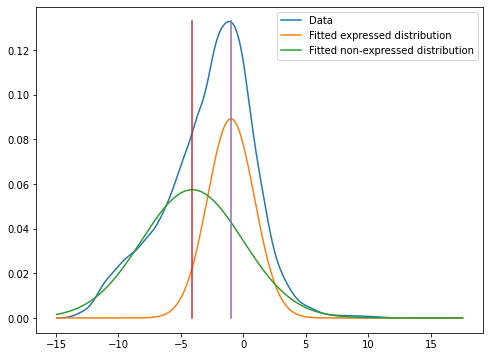

Fitted values: 
-0.9939601458422264 -4.0896665537056105


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM01397e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 230 / 452
original guess:  -1.0239094166568652 -0.386712369043

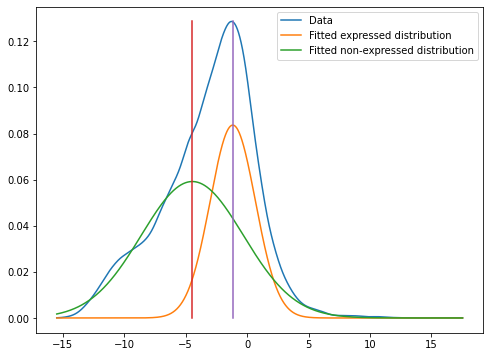

Fitted values: 
-1.1633505362103727 -4.456907650695815


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 231 / 452
original guess:  -1.665211845600874 -0.4305555812361

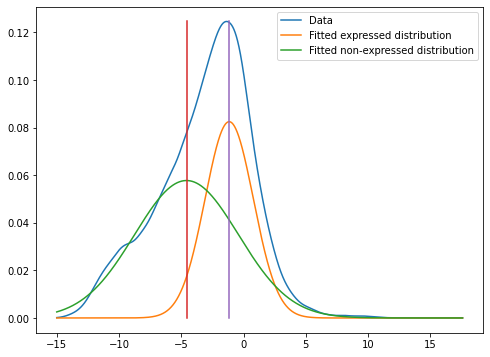

Fitted values: 
-1.1528540487494336 -4.579779813666893


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM01397e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 230 / 452
original guess:  -10.445701929252127 -0.948834174480

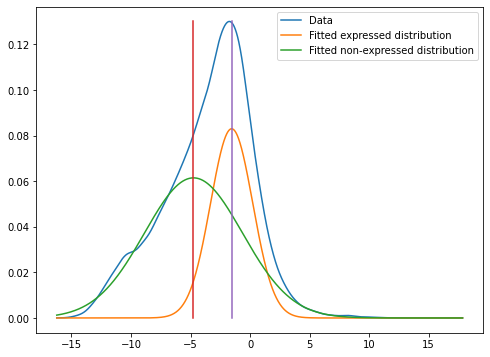

Fitted values: 
-1.5466975351177197 -4.7526321048273825


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02685r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 231 / 452
original guess:  -

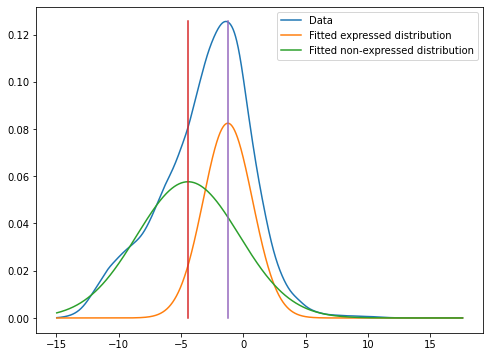

Fitted values: 
-1.2380583910690717 -4.4316120393425456


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM01397e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 230 / 452
original guess:  -4.666431055925825 -1.0806738402396

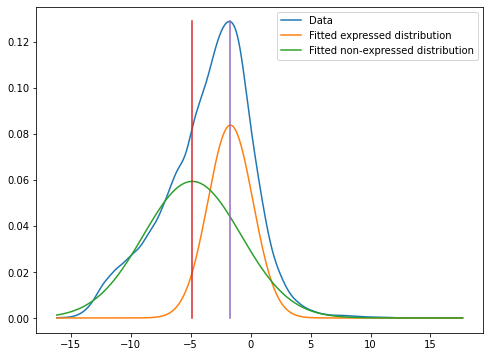

Fitted values: 
-1.687545432796492 -4.86989064557611


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM01397e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 230 / 452
original guess:  -3.1147611876936576 -2.120310532388981
fitted Amps:  0.05477705660213125 0.08204480948531627
fitted means:  -5.939220400059743 -2.9621631

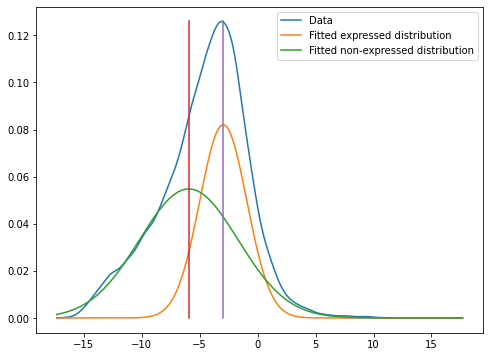

Fitted values: 
-2.9621631265707777 -5.939220400059743


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 232 / 452
original guess:  -3.1125722109935694 -1.7618087775055393
fitted Amps:  0.0559432100448

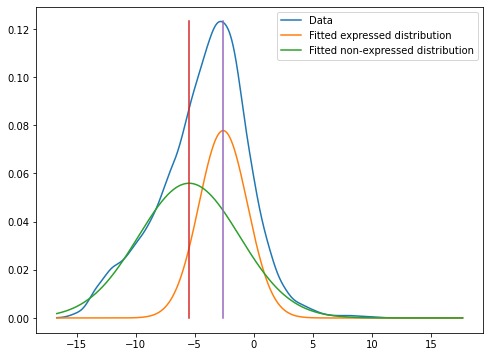

Fitted values: 
-2.578448301497321 -5.469890302066051


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

MAM02553e not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02936e not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02553e not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02579m not exists in the model
MAM02579m not exists in the model
MAM02579m not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM02959c not exists in the model


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


MAM01597e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01597e not exists in the model
MAM01803e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM01803e not exists in the model
MAM01597e not exists in the model
MAM02555e not exists in the model
MAM02774e not exists in the model
MAM03101m not exists in the model
MAM01316m not exists in the model
MAM02877m not exists in the model
MAM02871m not exists in the model
MAM01822c not exists in the model
MAM01957c not exists in the model
MAM02579m not exists in the model
MAM01964c not exists in the model
MAM01964r not exists in the model
MAM02001r not exists in the model
MAM02021r not exists in the model
MAM00240r not exists in the model
MAM02022r not exists in the model
score of the model: 231 / 452
original guess:  -4.133945952425247 -3.0241474137818

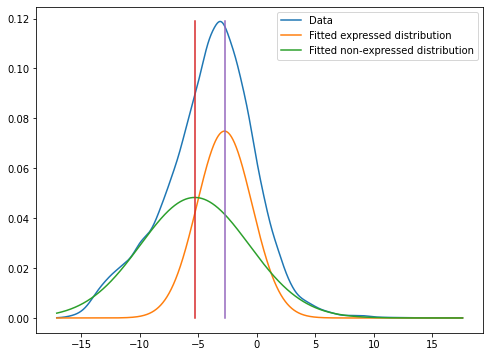

Fitted values: 
-2.749770361562263 -5.291629299908452


cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'
cobra\util\solver.py:416 UserWarning: solver sta

In [ ]:
model_path = "../models/2022March/"
mod_dict = {mod_name.stem: load_model(f"{mod_name}") for mod_name in Path(model_path).iterdir()}

task_scorer = TaskScoringPipeLine(
                   task_file_path = "../data/tasks/tasks_for_human1.json",
                   constr_name = "None",
                   use_first_guess=False,
                   model_compartment_format = "{}",
                   solver="gurobi"
)

task_scores = task_scorer(mod_dict, mg_TPMs)

In [163]:
for k, mod in output.items():
    print(k)
    with mod:
        rxns = [r.id for r in mod.reactions]
        for r in mod.exchanges:
            r.bounds = (0, 1000)

        for i, r in serum.iterrows():
            if r["rxn_id"] not in rxns:
                continue
            
            if pd.isna(r["rxn_id"]) or r["rxn_id"] == "MAR00569":
                continue
            if r["rxn_id"] in dmem_medium["human_gem_rxn"].to_list():
                
                mod.reactions.get_by_id(r["rxn_id"]).lower_bound = -min(max(r["concentration"], 0.01) * 3, 1000)
            else:
                mod.reactions.get_by_id(r["rxn_id"]).lower_bound = -min(max(r["concentration"], 1e-4), 1000)

        for r in ['MAR00656', 'MAR09152', 'MAR09153', 'MAR09154', 'MAR09386', 'MAR13067', 'MAR09048']:
            if r not in rxns:
                continue
            mod.reactions.get_by_id(r).lower_bound = -20

        for r in inorg_rxns:
            if r not in rxns:
                continue
            mod.reactions.get_by_id(r).lower_bound = -1000
        print(mod.summary(pfba(mod)))

C002A


cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.36                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.3                         
MAM02360e    1.45   MAM02040e     3.81                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.876                         
MAM03135e    1.06   MAM02159e    0.536                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.1                         
MAM02360e    1.45   MAM02040e     3.67                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e     1.06                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898   MAM02159e    0.338                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.1                         
MAM02360e    1.45   MAM02040e     4.38                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.924                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e      4.2                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.909                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.635                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.32                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.772                         
MAM03135e    1.06   MAM02159e    0.476                         
MAM02993e   0.898   MAM01797e    0.361                         
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e      3.5                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.873                         
MAM03135e    1.06   MAM02159e    0.667                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873   MAM02579e    0.373                         
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.05                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.876                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898   MAM01279e    0.356                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.7                         
MAM02360e    1.45   MAM02040e     3.65                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.923                         
MAM03135e    1.06   MAM02159e    0.515                         
MAM02993e   0.898   MAM02579e    0.372                         
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     4.19                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.787                         
MAM03135e    1.06   MAM02159e    0.666                         
MAM02993e   0.898   MAM02579e    0.372                         
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.54                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM01279e    0.354                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.1                         
MAM02360e    1.45   MAM02040e     4.22                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.708                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.15                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.935                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.3                         
MAM02360e    1.45   MAM02040e     3.85                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.876                         
MAM03135e    1.06   MAM02159e    0.503                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.1                         
MAM02360e    1.45   MAM02040e     3.85                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.876                         
MAM03135e    1.06   MAM02159e    0.519                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.34                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.787                         
MAM03135e    1.06   MAM02159e    0.517                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     3.67                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.935                         
MAM03135e    1.06   MAM02159e     0.74                         
MAM02993e   0.898   MAM02579e    0.468                         
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.49                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM01279e     0.37                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.24                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.894                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.635                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.41                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.922                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.13                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     3.93                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e     1.01                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     3.49                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.938                         
MAM03135e    1.06   MAM02159e    0.737                         
MAM02993e   0.898   MAM02579e    0.458                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e      3.5                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.876                         
MAM03135e    1.06   MAM02159e    0.667                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873   MAM02579e    0.373                         
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.41                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.916                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     3.78                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e     1.01                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.13                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.926                         
MAM03135e    1.06   MAM01279e    0.453                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.5                         
MAM02360e    1.45   MAM02040e     4.06                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.873                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.12                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.714                         
MAM03135e    1.06   MAM02159e    0.566                         
MAM02993e   0.898   MAM01797e    0.361                         
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.12                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.707                         
MAM03135e    1.06   MAM02159e    0.551                         
MAM02993e   0.898   MAM01797e    0.361                         
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     3.81                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.938                         
MAM03135e    1.06   MAM02159e    0.603                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.32                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.714                         
MAM03135e    1.06   MAM02159e    0.566                         
MAM02993e   0.898   MAM01797e    0.361                         
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.14                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM02159e    0.502                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     3.49                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06   MAM02159e    0.736                         
MAM02993e   0.898   MAM02579e    0.458                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.7                         
MAM02360e    1.45   MAM02040e     3.97                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM02159e    0.666                         
MAM02993e   0.898   MAM02579e    0.378                         
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.13                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.14                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.14                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.945                         
MAM03135e    1.06   MAM01279e    0.434                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.54                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM01279e    0.354                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.14                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.29                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.849                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.14                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.9                         
MAM02360e    1.45   MAM02040e     3.49                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e     1.07                         
MAM03135e    1.06   MAM02159e    0.469                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     3.93                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.936                         
MAM03135e    1.06   MAM01279e    0.443                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     3.95                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.935                         
MAM03135e    1.06   MAM01279e    0.444                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.02                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e     1.06                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.3                         
MAM02360e    1.45   MAM02040e     4.06                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.945                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.15                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.926                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.13                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.945                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.36                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     3.95                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06   MAM01279e     0.44                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.29                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.19                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.843                         
MAM03135e    1.06   MAM01797e    0.361                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.04                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.908                         
MAM03135e    1.06   MAM01279e     0.37                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.02                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e     1.06                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.02                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e     1.06                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     3.92                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e     1.01                         
MAM03135e    1.06   MAM01797e    0.379                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.837                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.19                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e     0.84                         
MAM03135e    1.06   MAM01279e    0.471                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     4.21                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.909                         
MAM03135e    1.06   MAM02159e    0.373                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.4                         
MAM02360e    1.45   MAM02040e     4.13                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.34                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.783                         
MAM03135e    1.06   MAM01279e    0.354                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.694                                              
MAM01986e   0.635                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.2                         
MAM02360e    1.45   MAM02040e     4.56                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                                              
MAM01365e   0.607                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     3.94                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM02159e    0.502                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     11.8                         
MAM02360e    1.45   MAM02040e     3.91                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e      2.3                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.781                         
MAM03135e    1.06   MAM02159e     0.65                         
MAM02993e   0.898   MAM02579e    0.378                         
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                                              
MAM01986e   0.642                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.3   MAM02046e     24.3     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     5.07                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.23   MAM02751e     1.94                         
MAM02896e    1.23   MAM02120e     1.17                         
MAM02426e    1.14   MAM01052e    0.413                         
MAM03135e    1.06                                              
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.701                                              
MAM01784e   0.605                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.5     MAR13082     2.95   
MAM02770e    2.31   MAM02039e       12                         
MAM02360e    1.45   MAM02040e     3.76                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.49                         
MAM02426e    1.14   MAM02120e     1.21                         
MAM02896e    1.09   MAM01052e    0.939                         
MAM03135e    1.06   MAM02159e    0.603                         
MAM02993e   0.898                                              
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES OBJECTIVES OBJECTIVES
    ID       FLUX       ID        FLUX        ID        FLUX   
MAM02630e    33.4   MAM02046e     24.4     MAR13082     2.95   
MAM02770e    2.31   MAM02039e     12.3                         
MAM02360e    1.45   MAM02040e     3.81                         
MAM01975e    1.26   MAM03971e     2.95                         
MAM01307e    1.24   MAM02751e     2.41                         
MAM02426e    1.14   MAM02120e      1.2                         
MAM02896e    1.09   MAM01052e    0.909                         
MAM03135e    1.06   MAM02159e     0.47                         
MAM02993e   0.898   MAM01797e    0.379                         
MAM03114e   0.873                                              
MAM01986e   0.844                                              
MAM01365e   0.809                                              
MAM02184e   0.711                                              
MAM01974e   0.693                       

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


In [158]:
rfc.rxn_tester.model_tester.tasks_scores

{'Full_1': 0.6971262318059613,
 'Full_2': 0.733622278902203,
 'Full_3': 0.7144193769593333,
 'Full_4': 0.7144193769593333,
 'Full_5': 0.7144193769593333,
 'Full_6': 0.6971262318059613,
 'Full_7': 0.6860350572742684,
 'Full_8': 0.7144193769593333,
 'Full_9': 0.7144193769593333,
 'Full_10': 0.7390109225435243,
 'Full_11': 0.7390109225435243,
 'Full_12': 0.7357503844810097,
 'Full_13': 0.7750748700826807,
 'Full_14': 0.745112467941099,
 'Full_15': 0.9155524997428063,
 'Full_16': 0.7793571518618444,
 'Full_17': 0.791284339285512,
 'Full_18': -1.6649810680026214,
 'Full_19': 1.1690843027848399,
 'Full_20': 1.508958581168004,
 'Full_21': 0.6971262318059613,
 'Full_22': 0.6971262318059613,
 'Full_23': 0.8624451524669572,
 'Full_24': 0.8517534083316426,
 'Full_25': 0.18186238611136987,
 'Full_26': 0.8357205646897811,
 'Full_27': 0.6110823205505611,
 'Full_28': 0.6954968305704086,
 'Full_31': 0.6482407053621105,
 'Full_32': 0.6611290013144905,
 'Full_33': 0.7815664485309042,
 'Full_34': 0.88775

In [169]:
rxn_score_dict = {}
# log2_data = np.log2(mg_TPMs)
log2_p_1_data = np.log2(mg_TPMs + 1)
for i, c in enumerate(mg_TPMs.columns):
    if c in output:
        exp = Expression(output[c], log2_p_1_data[c])
        rxn_score_dict[c] = exp.rxn_scores
    else:
        print("exclude ", c)

In [254]:
rxn_score_dict = {}
# log2_data = np.log2(mg_TPMs)
log2_p_1_data = np.log2(mg_RLE + 1)
for i, c in enumerate(mg_RLE.columns):
    if c in output:
        exp = Expression(output[c], log2_p_1_data[c])
        rxn_score_dict[c] = exp.rxn_scores
    else:
        print("exclude ", c)

In [255]:
sol_dic = {}

for i, c in enumerate(mg_RLE.columns):
    if c not in rxn_score_dict:
        continue
    
    with output[c] as mod:
        sol_v = mod.slim_optimize()
        obj_dic = {r.id : r.objective_coefficient for r in mod.reactions if r.objective_coefficient > 0}
        print(c, sol_v)
        
        RIPTiDe(mod,
                obj_frac=0.8,
                rxn_expr_score=rxn_score_dict[c],
                pruning_tol=1e-13,
                prune_rxns=True,
                return_pruning_coef=False
                )
        
        sol = mod.optimize(objective_sense="maximize")
        con = mod.problem.Constraint(mod.objective.expression, lb=sol.objective_value * 0.8)
        mod.add_cons_vars([con])
        
        mod.objective = {mod.reactions.get_by_id(r): v for r, v in obj_dic.items()}
        sol = pfba(mod)
        sol_df = _GIMME_post_process(sol)
        sol_df.to_frame().to_csv(f"../results/2022March/GEM/pfba_rle/{c}.csv")

C002A 6.107766034692721
8033 reactions are non-core reactions (fluxes smaller than 1e-13)
C003A 6.1077660346927205
8143 reactions are non-core reactions (fluxes smaller than 1e-13)
C004A 6.107766034692721
7837 reactions are non-core reactions (fluxes smaller than 1e-13)
C005A 4.844961240310078
8147 reactions are non-core reactions (fluxes smaller than 1e-13)
C006A 6.107766034692721
8062 reactions are non-core reactions (fluxes smaller than 1e-13)
C007A 6.107766034692721
8011 reactions are non-core reactions (fluxes smaller than 1e-13)
C008A 6.107766034692721
8027 reactions are non-core reactions (fluxes smaller than 1e-13)
C009A 6.107766034692721
7904 reactions are non-core reactions (fluxes smaller than 1e-13)
C010A 4.844961240310078
8292 reactions are non-core reactions (fluxes smaller than 1e-13)
C011A 6.107766034692721
7867 reactions are non-core reactions (fluxes smaller than 1e-13)
C012A 6.107766034692721
8129 reactions are non-core reactions (fluxes smaller than 1e-13)
R001A 4.8

In [173]:
for i, c in enumerate(mg_TPMs.columns):
    if c not in rxn_score_dict:
        continue
    
    with output[c] as mod:
        sol_v = mod.slim_optimize()
        obj_dic = {r.id : r.objective_coefficient for r in mod.reactions if r.objective_coefficient > 0}
        print(c, sol_v)
        
        RIPTiDe(mod,
                obj_frac=0.8,
                rxn_expr_score=rxn_score_dict[c],
                pruning_tol=1e-13,
                prune_rxns=True,
                return_pruning_coef=False
                )
        
        sol = mod.optimize(objective_sense="maximize")
        con = mod.problem.Constraint(mod.objective.expression, lb=sol.objective_value * 0.8)
        mod.add_cons_vars([con])
        
#         mod.objective = {mod.reactions.get_by_id(r): v for r, v in obj_dic.items()}
#         sol = pfba(mod)
#         sol_df = _GIMME_post_process(sol)
#         sol_df.to_frame().to_csv(f"../results/2022March/GEM/pfba/{c}.csv")

        samp_df = sample(mod, n=500).T
        for ind in samp_df.index:
            if "_R_" in ind:
                samp_df.loc[ind, :] = -samp_df.loc[ind, :]
        samp_df["rxn_id"] = samp_df.index.to_series().apply(lambda x: x[3:] if "_F_" in x or "_R_" in x else x)
        samp_df = samp_df.groupby("rxn_id").sum()
        samp_df.to_csv(f"../results/2022March/GEM/sampled/{c}.csv")

C002A 6.107766034692721
8071 reactions are non-core reactions (fluxes smaller than 1e-13)
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpr03w2qtr.lp
Reading time = 0.10 seconds
: 4157 rows, 23308 columns, 113878 nonzeros
C003A 6.1077660346927205
8187 reactions are non-core reactions (fluxes smaller than 1e-13)
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmp5hqoyfpo.lp
Reading time = 0.10 seconds
: 4192 rows, 23418 columns, 115090 nonzeros
C004A 6.107766034692721
7886 reactions are non-core reactions (fluxes smaller than 1e-13)
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmpxkjlx9sb.lp
Reading time = 0.09 seconds
: 3853 rows, 22088 columns, 107440 nonzeros
C005A 4.844961240310078
8142 reactions are non-core reactions (fluxes smaller than 1e-13)
Read LP format model from file C:\Users\user\AppData\Local\Temp\tmphx7yy85p.lp
Reading time = 0.10 seconds
: 3955 rows, 22968 columns, 111630 nonzeros
C006A 6.107766034692721
8108 reacti

RuntimeError: Can not escape sampling region, model seems numerically unstable :( Reporting the model to https://github.com/opencobra/cobrapy/issues will help us to fix this :)

In [18]:
all_dfs = []

for i, c in enumerate(mg_RLE.columns):
    df = pd.read_csv(f"../results/2022March/GEM/pfba/{c}.csv", index_col=0)["fluxes"]
    df.name = c
    all_dfs.append(df)
    
mg_df = pd.concat(all_dfs, axis=1)

In [176]:
mg_df.fillna(0).to_csv("../results/2022March/ML/data/pfba.csv")

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pipeGEM.plotting.heatmap import plot_clustermap
from pipeGEM.plotting.scatter import plot_embedding, plot_PCA

In [8]:
labels = pd.read_csv("../data/all_info/labels.csv", sep='\t')
labels.loc[(labels["group"] == 4) & (labels["subgroup"] == "met"), "group"] = 5

In [9]:
gb = labels.groupby("group")["sample"].apply(lambda x: list(x))
groups = {f"G{i+1}": [g + "A" for g in gs] for i, gs in enumerate(gb)}

In [ ]:
# rxn scores

In [196]:
exp_df = pd.DataFrame(rxn_score_dict).dropna(how="all").fillna(0.0)

In [197]:
exp_df.to_csv("../results/2022March/ML/data/rxn_score.csv")

saving  ../results/2022March/GEM/rxn_scores_PCA.png


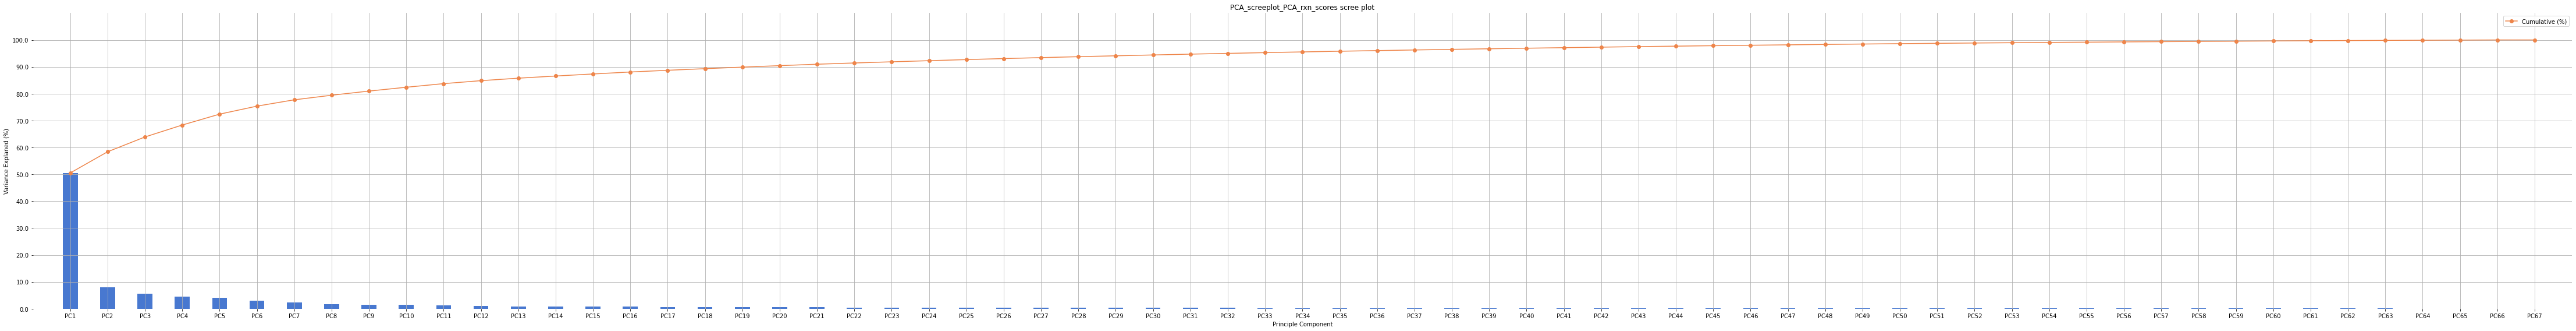

saving  ../results/2022March/GEM/rxn_scores_PCA.png


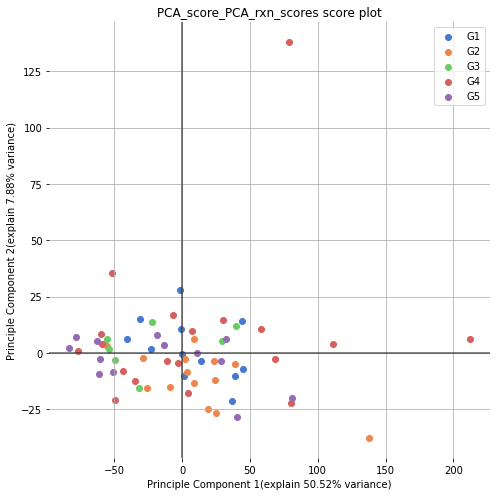

,C002A,C003A,C004A,C005A,C006A,C007A,C008A,C009A,C010A,C011A,...,R047A,R048A,R049A,R050A,R051A,R053A,R054A,R055A,R056A,R057A
PC1,4.478030e+01,4.411157e+01,3.913550e+01,1.392128e+01,3.713249e+01,1.148267e+00,-4.050959e+01,-2.312840e+01,-1.618365e+00,-3.039379e-01,...,9.150893e+00,5.821473e+01,1.946339e+01,1.379192e+02,-7.477610e+01,8.060708e+01,2.119358e+02,2.317387e+01,1.092087e+01,-5.200762e+01
PC2,-7.411159e+00,1.422670e+01,-1.031412e+01,-3.589820e+00,-2.158223e+01,-1.027210e+01,6.248013e+00,1.770312e+00,2.788344e+01,-5.545966e-01,...,6.183155e+00,1.062294e+01,-2.476467e+01,-3.785212e+01,1.927626e-01,-2.227148e+01,6.012889e+00,-3.756033e+00,3.309852e-02,3.524644e+01
PC3,-1.535322e+01,-2.264964e+01,-1.707669e+01,-2.198278e+01,-9.309903e+00,-8.859128e+00,-7.060664e+00,-1.589211e+01,-4.295571e+01,-1.216568e+01,...,-1.699503e+01,1.547766e+01,-7.755617e+00,4.413550e+01,4.001199e+00,5.283469e+00,3.707296e+01,-5.386350e-01,1.097675e+01,7.320891e+01
PC4,3.878226e+00,7.567048e+00,1.611562e+01,7.691490e+00,4.632757e+00,6.871837e+00,2.478306e+00,4.818358e+00,1.594074e+01,9.450593e+00,...,1.281632e+01,6.390837e-01,7.516152e+00,-4.335335e+01,-3.262573e+00,5.712603e+00,1.473783e+01,-2.742792e+00,1.435322e+00,9.697485e+01
PC5,-2.150807e+01,-2.229173e+00,-3.369372e+00,2.845485e+00,-2.486134e+01,-1.065456e+00,7.093407e+00,4.496897e+00,1.089505e+01,1.273952e+00,...,-1.268678e+00,2.945389e+01,-5.461598e+00,-3.448178e+01,1.129714e+00,-2.947927e+00,7.707972e+01,-6.073720e+00,-1.213833e+00,-2.953798e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC63,-1.158885e-01,6.445599e-01,-2.134475e-01,8.097657e-01,2.707349e-01,-2.291754e+00,-3.379367e+00,5.942437e+00,4.145221e-01,5.598457e-02,...,-3.416541e-01,2.236547e-01,-9.853188e-01,-4.199289e-02,5.531917e-01,-1.331819e-01,1.152513e-01,2.780123e-01,8.614359e-02,-6.760322e-03
PC64,-4.698709e-01,-6.634175e-01,-5.074204e-02,4.707822e-01,5.968325e-01,1.074276e-01,7.549914e+00,-5.776023e+00,1.097524e-01,7.073033e-01,...,1.646692e-01,-1.839949e-01,3.551315e-01,-1.254903e-01,1.113437e-01,5.010803e-01,-3.493979e-02,2.114328e-01,2.291316e+00,4.266562e-02
PC65,1.909329e-01,-4.710692e-01,3.643175e-01,-5.165631e-01,3.505146e-01,1.791164e+00,-3.530436e+00,-1.686936e-01,-1.484057e-01,-3.590878e-02,...,-2.172002e-01,4.285887e-02,-5.431293e-01,5.308862e-03,-4.175766e-01,-1.594779e-01,4.141483e-02,-3.808606e-01,-2.711913e-02,-2.995366e-02
PC66,7.744036e-02,3.680891e-01,-4.377586e-01,-7.844503e-01,1.969243e-01,8.547271e-01,3.332366e+00,1.336696e+00,2.934357e-01,2.593414e-01,...,2.481376e-02,1.305726e-01,3.683606e-01,-1.827130e-03,7.949209e-01,-7.496968e-02,-8.012832e-02,-6.741145e-03,-7.422239e-02,1.524001e-02


In [198]:
plot_PCA(exp_df.fillna(0), groups=groups, title="PCA_rxn_scores", prefix="",
         transform_func=None,
         file_name="../results/2022March/GEM/rxn_scores_PCA.png", dpi=450)

saving  ../results/2022March/GEM/rxn_scores_UMAP.png


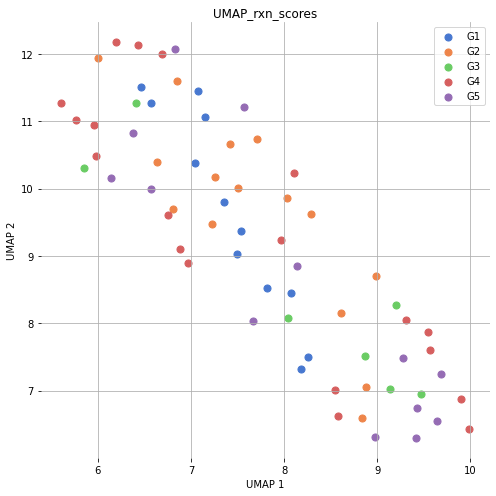

{'g': <Figure size 504x504 with 1 Axes>}

In [199]:
plot_embedding(exp_df.fillna(0), groups=groups, title="UMAP_rxn_scores", reducer="UMAP", 
               transform_func=None, random_state=42, file_name="../results/2022March/GEM/rxn_scores_UMAP.png", dpi=450)

In [203]:
subsystem_dic = {r.id: r.subsystem for r in c_model.reactions}

In [208]:
exp_df["subsystem"] = exp_df.index.map(subsystem_dic)
sub_df = exp_df.groupby("subsystem").mean()

In [218]:
sub_df = sub_df.reset_index().melt(id_vars="subsystem")
sub_df["group"] = sub_df["variable"].map({vi: k for k, v in groups.items() for vi in v})

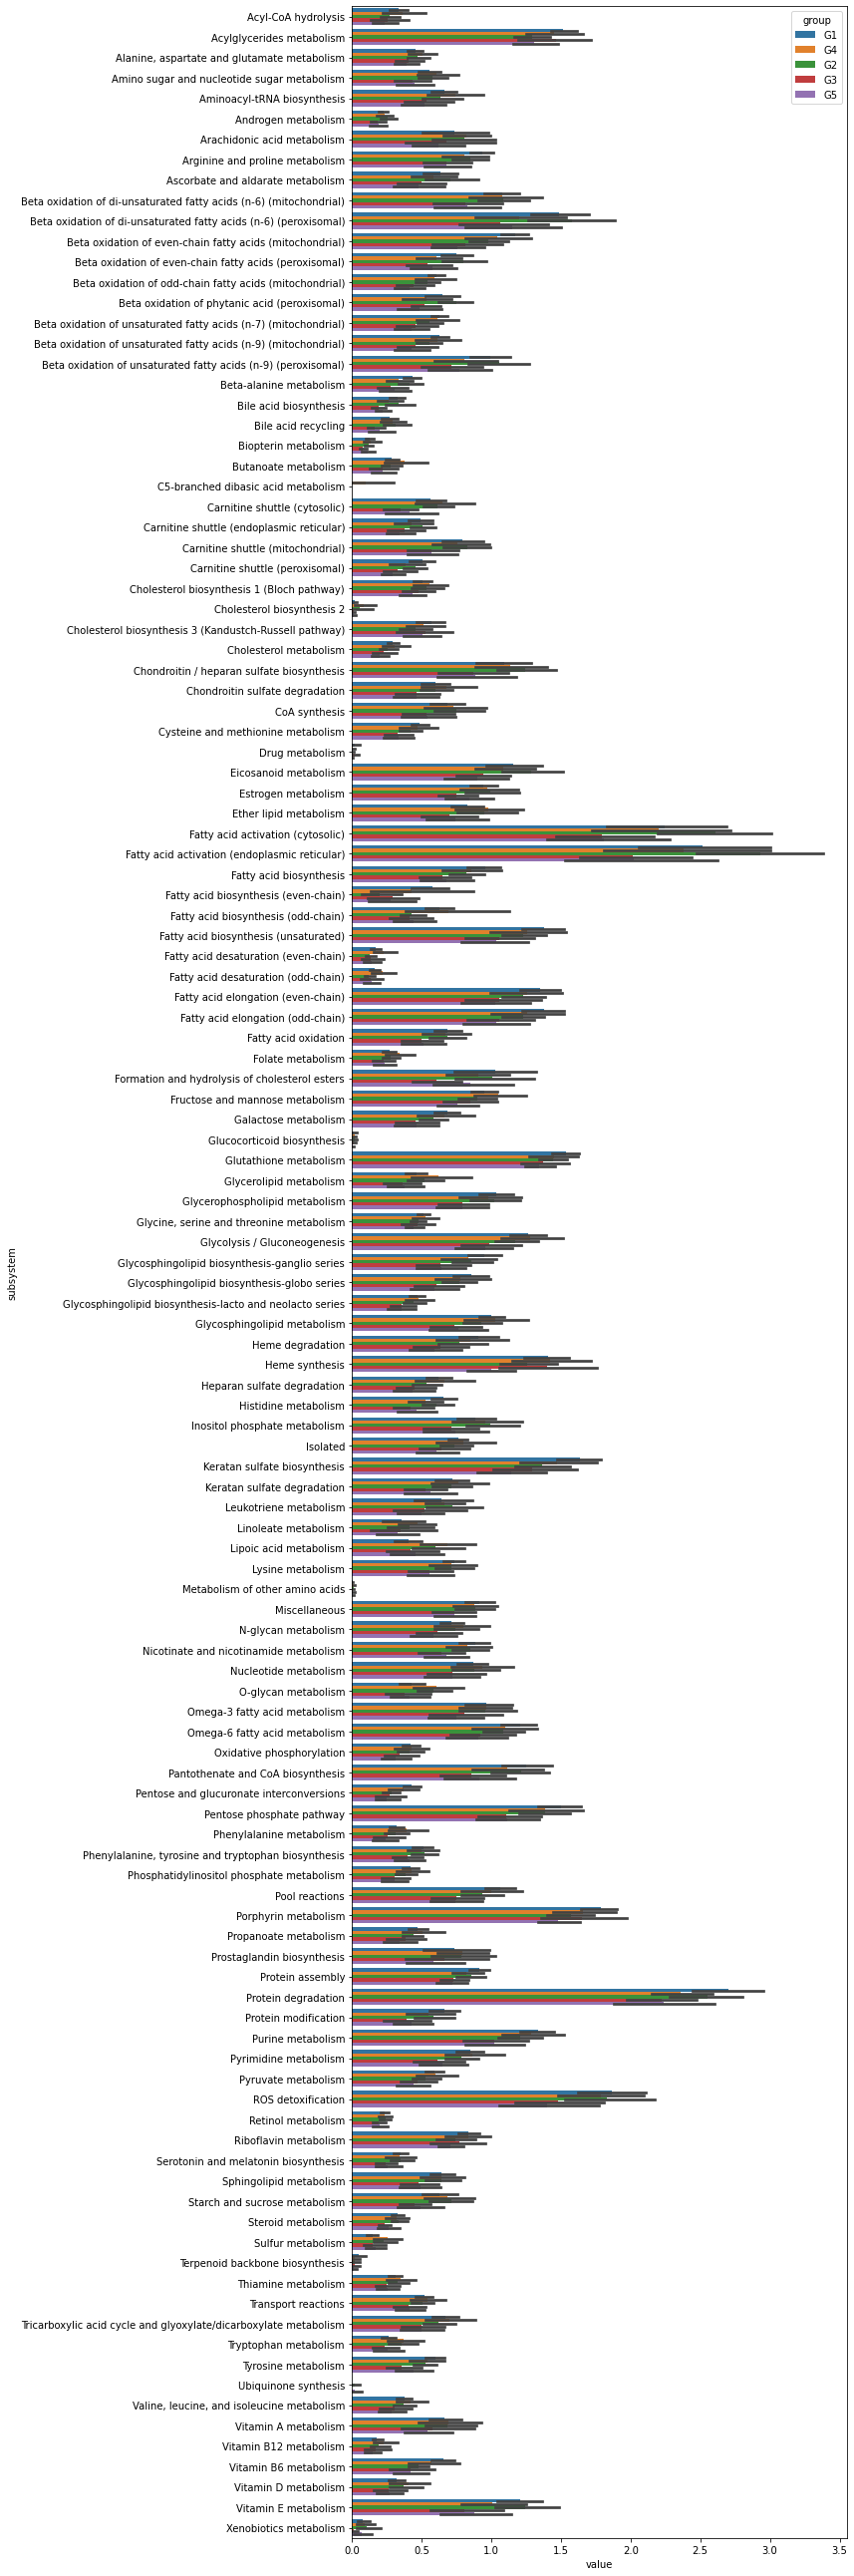

In [229]:
plt.figure(figsize=(12, 36))
sns.barplot(data=sub_df, y="subsystem", x="value", hue="group")

plt.tight_layout()
plt.savefig("../results/2022March/GEM/rxn_barplot.png", dpi=400)

In [ ]:
# DGE on model

In [234]:
de21 = pd.read_csv("../results/2022March/DEG/tables/DEG_list_2_1.tsv", sep='\t')

In [239]:
degs = set([g.id for g in human.genes]) & set(de21["DGE"].apply(lambda x: x[:x.index(".")]))

In [249]:
de_sub = []
de_met = []
for g in degs:
    de_sub.extend([r.subsystem for r in human.genes.get_by_id(g).reactions])
    de_met.extend([m.name for r in human.genes.get_by_id(g).reactions for m in r.metabolites])

In [250]:
de_met

['20-OH-LTB4',
 '20-oxo-LTB4',
 'H+',
 'NAD+',
 'NADH',
 'chloral hydrate',
 'H+',
 'H2O',
 'NAD+',
 'NADH',
 'trichloroethanol',
 '3alpha,7alpha-dihydroxy-5beta-cholestan-26-al',
 '5beta-cholestane-3alpha,7alpha,26-triol',
 'H+',
 'NAD+',
 'NADH',
 '20-OH-LTB4',
 '20-oxo-LTB4',
 'H+',
 'NAD+',
 'NADH',
 '5-hydroxyindoleacetaldehyde',
 '5-hydroxytryptophol',
 'H+',
 'NADP+',
 'NADPH',
 'glyceraldehyde',
 'glycerol',
 'H+',
 'NADP+',
 'NADPH',
 'formaldehyde',
 'H+',
 'methanol',
 'NAD+',
 'NADH',
 'H+',
 'NAD+',
 'NADH',
 'retinal',
 'retinol',
 '20-OH-LTB4',
 '20-oxo-LTB4',
 'H+',
 'NAD+',
 'NADH',
 '(R)-S-lactoylglutathione',
 'D-lactaldehyde',
 'GSH',
 'H+',
 'NAD+',
 'NADH',
 'acetaldehyde',
 'ethanol',
 'H+',
 'NAD+',
 'NADH',
 'formaldehyde',
 'formylglutathione',
 'GSH',
 'H+',
 'NAD+',
 'NADH',
 'H+',
 'NAD+',
 'NADH',
 'retinal',
 'retinol',
 '3,4-dihydroxymandelaldehyde',
 '3,4-dihydroxyphenylethyleneglycol',
 'H+',
 'NAD+',
 'NADH',
 'glyceraldehyde',
 'glycerol',
 'H+',
 'N

In [ ]:
# pfba 

In [19]:
mg_df = (mg_df / mg_df.loc["MAR13082"].dropna(how="all")).fillna(0)

saving  ../results/2022March/GEM/pfba_PCA.png


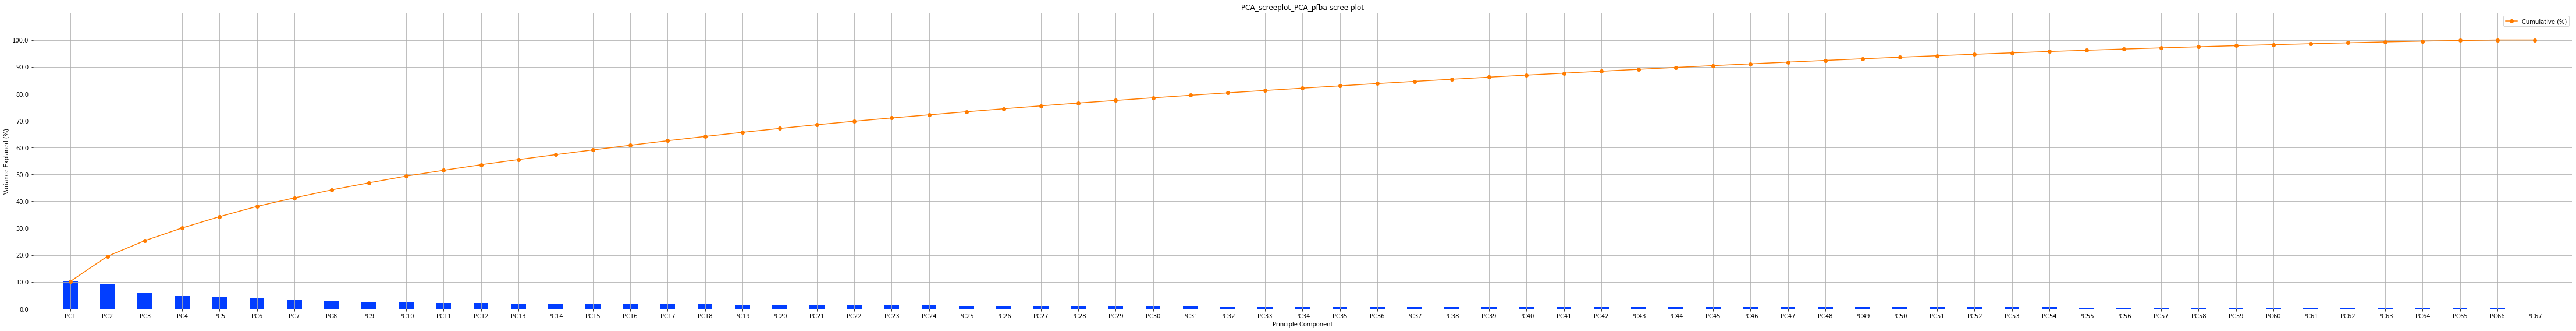

saving  ../results/2022March/GEM/pfba_PCA.png


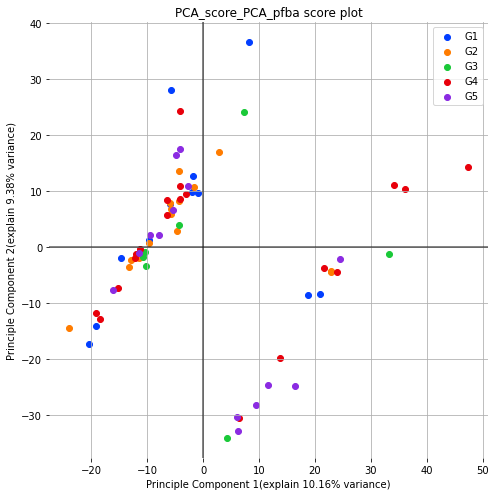

,C002A,C003A,C004A,C005A,C006A,C007A,C008A,C009A,C010A,C011A,...,R047A,R048A,R049A,R050A,R051A,R053A,R054A,R055A,R056A,R057A
PC1,-2.054538e+00,-5.981752e+00,-5.791137e+00,1.871989e+01,-1.473894e+01,-9.640919e+00,-1.795249e+00,8.288176e+00,2.088935e+01,-1.914324e+01,...,-1.696659e+00,-1.917926e+01,-5.804655e+00,2.286792e+01,-4.842061e+00,-1.845912e+01,4.732559e+01,-4.320508e+00,-1.144111e+01,-4.082459e+00
PC2,9.862907e+00,7.681847e+00,2.800091e+01,-8.489679e+00,-1.972858e+00,1.324584e+00,1.267718e+01,3.659086e+01,-8.361146e+00,-1.402050e+01,...,1.073591e+01,-1.170842e+01,5.888397e+00,-4.189455e+00,1.642860e+01,-1.287309e+01,1.430207e+01,8.329082e+00,-9.848505e-01,2.437978e+01
PC3,-7.662447e-01,3.674233e+00,7.823698e+01,9.823641e+00,1.203337e+01,3.310370e+00,-5.074619e-01,-1.240822e+01,2.164839e+00,-5.606077e+00,...,-8.883926e+00,-7.751409e+00,4.143362e-01,1.927950e+00,-1.852835e+01,1.043033e+01,2.746171e+00,-1.666860e+00,3.225102e+00,-3.904250e+00
PC4,1.161497e+00,-5.700024e+00,3.469971e+01,-9.691480e+00,-2.627802e+01,-5.650831e+00,-6.577073e+00,-2.785841e+00,1.835121e+00,8.313416e+00,...,4.234177e+00,1.058469e+01,-1.497918e+00,5.095409e+00,1.248507e+01,-2.641777e+01,-2.049198e+01,1.594638e+00,-4.568922e+00,-1.678613e+01
PC5,-8.480937e+00,-3.095930e+00,8.149389e+00,-4.820400e+00,-9.748790e+00,2.528779e+00,3.942813e+00,3.126371e+00,-1.167105e+01,1.097135e+01,...,-1.287003e+00,1.064408e+01,-1.071499e+01,-1.258148e+01,9.879336e+00,-1.718392e+01,3.947178e+01,-8.630431e+00,6.778567e+00,2.492592e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC63,-3.712606e+00,1.497955e+00,1.826169e-02,-2.341999e+00,5.679055e-01,-7.025167e-01,1.180414e+00,-7.489761e-01,2.482453e+00,4.240356e-01,...,2.282523e-01,1.727016e-01,-3.239832e-01,-2.365322e+00,-1.264287e-01,-2.784229e-01,1.551431e-01,1.094559e+00,-2.422171e-01,-2.197844e-01
PC64,-5.027115e+00,4.544740e-01,7.941378e-02,-2.270246e+00,-4.855586e-01,-1.960871e-01,-4.213567e-01,5.363938e-01,2.509630e-01,1.850882e-01,...,-3.437074e-01,8.877073e-01,-3.129463e+00,1.960636e+00,-5.847281e-01,1.262173e+00,8.321352e-02,4.133219e+00,1.495428e+00,2.192726e-02
PC65,9.109276e-01,4.261567e-01,-1.090211e-01,3.300634e-01,-1.708854e-01,-1.978901e+00,-1.270110e+00,4.026855e-02,-3.787581e-01,-3.441768e-01,...,2.873148e-01,7.689148e-01,-3.885483e-01,4.216995e-01,-1.719159e-01,1.511070e-01,9.873979e-02,-1.083745e-02,-9.102333e-01,-3.043959e-01
PC66,2.712258e+00,-3.185221e-01,5.672184e-03,-1.700127e+00,-9.902390e-02,1.429726e+01,-1.812146e-01,-2.093912e-01,7.260745e-01,7.364570e-01,...,-2.647106e-01,9.109071e-01,-4.606970e-01,-1.913201e+00,8.903004e-02,1.688877e-01,6.073681e-02,-8.914815e-01,-6.025670e-01,2.131626e-03


In [20]:
plot_PCA(mg_df, groups=groups, title="PCA_pfba", prefix="",
         palette="bright",
         transform_func=None,
         file_name="../results/2022March/GEM/pfba_PCA.png", dpi=450)

saving  ../results/2022March/GEM/pfba_UMAP.png


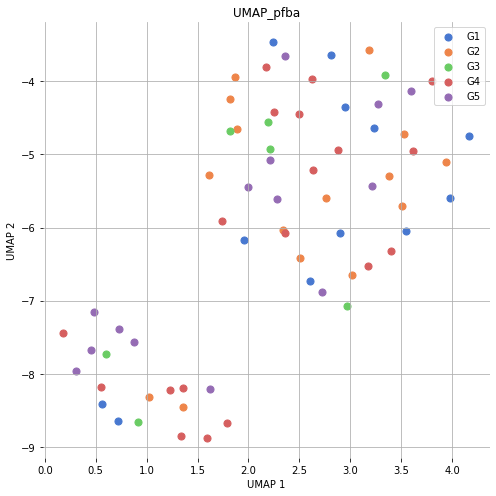

{'g': <Figure size 504x504 with 1 Axes>}

In [21]:
plot_embedding(mg_df, groups=groups, title="UMAP_pfba", reducer="UMAP", 
               transform_func=None, random_state=42, file_name="../results/2022March/GEM/pfba_UMAP.png", dpi=450)

<AxesSubplot:>

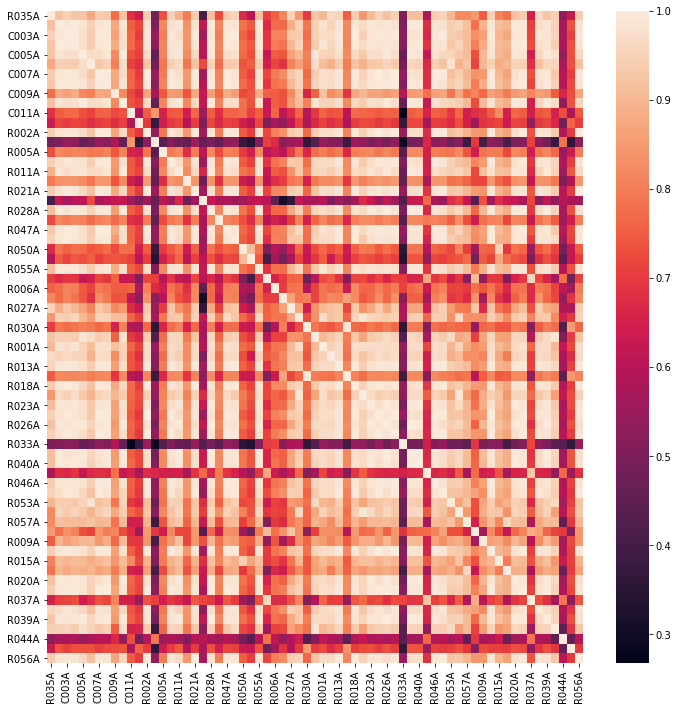

In [22]:
plt.figure(figsize=(12, 12))
sns.heatmap(mg_df[groups["G1"]+ groups["G2"]+ groups["G3"]+ groups["G4"]+ groups["G5"]].corr())